State Farm Distracted Drivers
=============

Prev Exercises: Udacity:DeepLearning:TensorFlow:notMNIST  

Fit Multi Layer Perceptron (MLP) with Rectified Linear Units (RELUs) SGD with random image rotation (TensorFlow)
------------

In [1]:
import sys
print sys.version

from joblib import Parallel, delayed  
import multiprocessing
nCores = multiprocessing.cpu_count() - 2 # Allow other apps to run
print 'nCores: %d' % (nCores)

from datetime import datetime, time
print 'now: %s' % str(datetime.now())

2.7.11 (default, Jan 28 2016, 14:07:46) 
[GCC 4.2.1 Compatible Apple LLVM 7.0.2 (clang-700.1.81)]
nCores: 14
now: 2016-05-24 10:30:24.167399


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display, Image
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects.lib import grid
from rpy2.robjects.lib import ggplot2
import rpy2.robjects.pandas2ri

import numpy as np
np.set_printoptions(precision=4, suppress=True)
import os
import pandas as pd
from scipy import ndimage
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

import tensorflow as tf
print 'tf.__version__:%s' % str(tf.__version__)

%run img_utils.py

tf.__version__:0.8.0


/usr/local/lib/python2.7/site-packages/rpy2/robjects/lib/ggplot2.py:59: UserWarning: This was designed againt ggplot2 version 2.0.0 but you have 2.1.0
  warnings.warn('This was designed againt ggplot2 version %s but you have %s' % (TARGET_VERSION, ggplot2.__version__))


## Analytics Specs

### This Project

In [3]:
%run img_glbSpec_SFDD_ImgSz_64.py

imported img_glbSpec_SFDD_Img_Sz_64.py


In [4]:
# print '\nglbDataFile: %s' % (glbDataFile)

print '\nglbRspClass: %s' % (glbRspClass)
print 'glbRspClassN: %d' % (glbRspClassN)
print 'glbRspClassDesc: '; print(glbRspClassDesc)

print '\nglbImg:'; print(glbImg)

print '\nglbTfwVarSeed: %d' % (glbTfwVarSeed)

print '\nglbPickleFile: %s' % (glbPickleFile)


glbRspClass: ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']
glbRspClassN: 10
glbRspClassDesc: 
{'c9': 'talking to passenger', 'c8': 'hair and makeup', 'c3': 'texting - left', 'c2': 'talking on the phone - right', 'c1': 'texting - right', 'c0': 'normal driving', 'c7': 'reaching behind', 'c6': 'drinking', 'c5': 'operating the radio', 'c4': 'talking on the phone - left'}

glbImg:
{'color': False, 'crop': {'x': (80, 560)}, 'shape': (480, 640, 3), 'pxlDepth': 255.0, 'center_scale': True, 'size': 64}

glbTfwVarSeed: 131

glbPickleFile: {'models': 'data/img_M_SFDD_ImgSz_64.pickle', 'data': 'data/img_D_SFDD_ImgSz_64.pickle'}


## Import Data

### This Project

In [16]:
%run img_utils.py
glbObsFitIdn, glbObsFitFtr, glbObsFitRsp, \
glbObsVldIdn, glbObsVldFtr, glbObsVldRsp, \
glbObsNewIdn, glbObsNewFtr, glbObsNewRsp, \
sbtNewCorDf, \
_ = myimportDbs(glbPickleFile['data'])

glbObsTrnIdn = glbObsFitIdn + glbObsVldIdn
glbObsTrnFtr = np.vstack((glbObsFitFtr, glbObsVldFtr))
glbObsTrnRsp = np.concatenate((glbObsFitRsp, glbObsVldRsp))

print('Fit pickled set:', 
      len(glbObsFitIdn), glbObsFitFtr.shape, glbObsFitRsp.shape)
print('Vld pickled set:', 
      len(glbObsVldIdn), glbObsVldFtr.shape, glbObsVldRsp.shape)
print('Trn pickled set:', 
      len(glbObsTrnIdn), glbObsTrnFtr.shape, glbObsTrnRsp.shape)    
print('New pickled set:', 
      len(glbObsNewIdn), glbObsNewFtr.shape, glbObsNewRsp.shape)

Importing database from data/img_D_SFDD_ImgSz_64.pickle...
('Fit pickled set:', 18077, (18077, 64, 64), (18077,))
('Vld pickled set:', 4347, (4347, 64, 64), (4347,))
('Trn pickled set:', 22424, (22424, 64, 64), (22424,))
('New pickled set:', 79726, (79726, 64, 64), (79726,))


First reload the data we generated in `1_notmist.ipynb`.

In [7]:
# pickle_file = 'data/notMNIST.pickle'

# with open(pickle_file, 'rb') as f:
#   save = pickle.load(f)
#   glbXFit = save['glbXFit']
#   glbYFit = save['glbYFit']
#   glbXVld = save['glbXVld']
#   glbYVld = save['glbYVld']
#   glbXNew = save['glbXNew']
#   glbYNew = save['glbYNew']
#   del save  # hint to help gc free up memory
#   print('Training set', glbXFit.shape, glbYFit.shape)
#   print('Validation set', glbXVld.shape, glbYVld.shape)
#   print('Test set', glbXNew.shape, glbYNew.shape)

Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [17]:
def lclreformatData(I, X, Y):  
  X = X.reshape((-1, glbImg['size'] * glbImg['size'])).astype(np.float32)
  # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
  Y = (np.arange(glbRspClassN) == Y[:,None]).astype(np.float32)
  return I, X, Y

glbITrn, glbXTrn, glbYTrn = lclreformatData(
    glbObsTrnIdn, glbObsTrnFtr, glbObsTrnRsp)
glbIFit, glbXFit, glbYFit = lclreformatData(
    glbObsFitIdn, glbObsFitFtr, glbObsFitRsp)
glbIVld, glbXVld, glbYVld = lclreformatData(
    glbObsVldIdn, glbObsVldFtr, glbObsVldRsp)
glbINew, glbXNew, glbYNew = lclreformatData(
    glbObsNewIdn, glbObsNewFtr, glbObsNewRsp)

print('Trn reshaped set:', len(glbITrn), glbXTrn.shape, glbYTrn.shape)
print('Fit reshaped set:', len(glbIFit), glbXFit.shape, glbYFit.shape)
print('Vld reshaped set:', len(glbIVld), glbXVld.shape, glbYVld.shape)
print('New reshaped set:', len(glbINew), glbXNew.shape, glbYNew.shape)

('Trn reshaped set:', 22424, (22424, 4096), (22424, 10))
('Fit reshaped set:', 18077, (18077, 4096), (18077, 10))
('Vld reshaped set:', 4347, (4347, 4096), (4347, 10))
('New reshaped set:', 79726, (79726, 4096), (79726, 10))


In [18]:
# Check how much incremental memory is used for Fit obs
del glbObsFitIdn, glbObsFitFtr, glbObsFitRsp
del glbIFit, glbXFit, glbYFit

# Check how much incremental memory is used for Trn obs
# del glbObsTrnIdn, glbObsTrnFtr, glbObsTrnRsp
# del glbITrn, glbXTrn, glbYTrn

In [19]:
print glbObsFitFtr.shape
# print glbObsTrnFtr.shape

NameError: name 'glbObsFitFtr' is not defined

## Fit MLP with RELUs (TensorFlow)

Turn the logistic regression example with SGD into a 1-hidden layer neural network with rectified linear units (nn.relu()) and nRELUs hidden nodes. This model should improve your validation / test accuracy_score.

imported img_glbSpec_SFDD_Img_Sz_64.py

Logistic Regression (TensorFlow): nObsFit:  100; nObsBtc:   16; rotatePby: 0.2000; rotateMaxAgl:  10; nRELUs:   128; nStepsTfw:   10; lrnRateTfw:0.5000 
  visualize: True; newObs: False; verbose: False


max Pby for cls: c0; desc: normal driving; proba: 0.4731; nObs: 1
  img_29701.jpg:
  plot_occlusion:


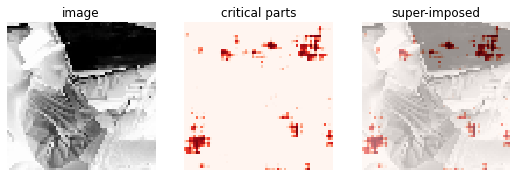

  Proba:
[ 0.4731  0.0011  0.0016  0.3912  0.0884  0.0083  0.0001  0.0024  0.0029
  0.0309]
min Pby for cls: c0; desc: normal driving; proba: 0.2451; nObs: 1
  img_86363.jpg:
  plot_occlusion:


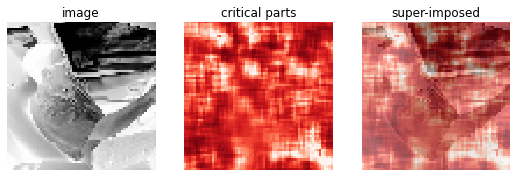

  Proba:
[ 0.2451  0.1808  0.1241  0.0272  0.2366  0.0868  0.      0.0014  0.0979
  0.0001]
  next best class: talking on the phone - left


max Pby for cls: c1; desc: texting - right; proba: 0.1296; nObs: 1
  img_16842.jpg:
  plot_occlusion:


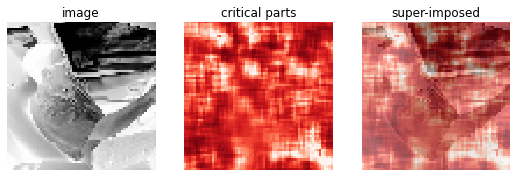

  Proba:
[ 0.0934  0.1296  0.1011  0.1242  0.1251  0.0779  0.1271  0.0732  0.0901
  0.0583]
min Pby for cls: c1; desc: texting - right; proba: 0.1296; nObs: 1
  img_16842.jpg:
  plot_occlusion:


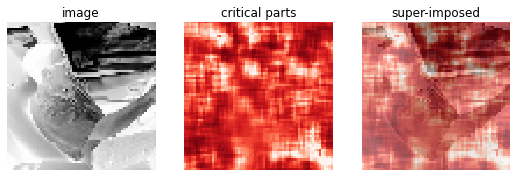

  Proba:
[ 0.0934  0.1296  0.1011  0.1242  0.1251  0.0779  0.1271  0.0732  0.0901
  0.0583]
  next best class: drinking


max Pby for cls: c2; desc: talking on the phone - right; proba: 1.0000; nObs: 1
  img_18370.jpg:
  plot_occlusion:


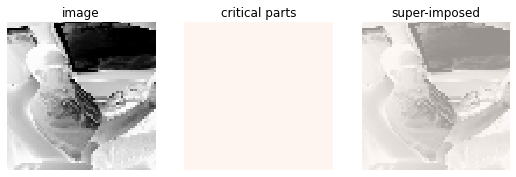

  Proba:
[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
min Pby for cls: c2; desc: talking on the phone - right; proba: 0.1228; nObs: 1
  img_13515.jpg:
  plot_occlusion:


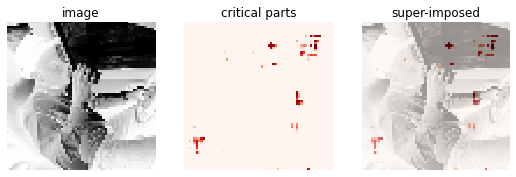

  Proba:
[ 0.0934  0.1078  0.1228  0.1172  0.1125  0.0793  0.0984  0.1131  0.0913
  0.0644]
  next best class: texting - left


max Pby for cls: c3; desc: texting - left; proba: 0.9999; nObs: 1
  img_72000.jpg:
  plot_occlusion:


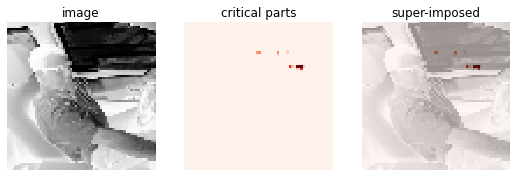

  Proba:
[ 0.      0.0001  0.      0.9999  0.      0.      0.      0.      0.      0.    ]
min Pby for cls: c3; desc: texting - left; proba: 0.1219; nObs: 1
  img_76964.jpg:
  plot_occlusion:


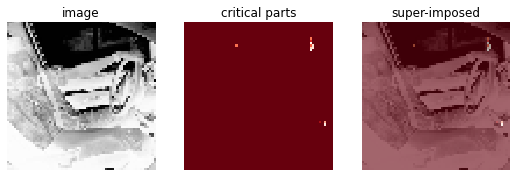

  Proba:
[ 0.0967  0.1072  0.1189  0.1219  0.1147  0.08    0.0947  0.1091  0.0957
  0.061 ]
  next best class: talking on the phone - right


max Pby for cls: c4; desc: talking on the phone - left; proba: 0.2652; nObs: 1
  img_92906.jpg:
  plot_occlusion:


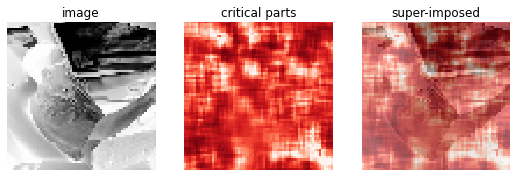

  Proba:
[ 0.0596  0.0551  0.0202  0.0437  0.2652  0.0271  0.0579  0.2334  0.0654
  0.1724]
min Pby for cls: c4; desc: talking on the phone - left; proba: 0.1950; nObs: 1
  img_6011.jpg:
  plot_occlusion:


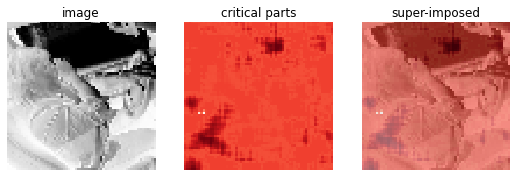

  Proba:
[ 0.1297  0.0815  0.0446  0.1467  0.195   0.0636  0.0498  0.0894  0.157
  0.0427]
  next best class: hair and makeup


max Pby for cls: c5; desc: operating the radio; proba: 0.8866; nObs: 1
  img_37865.jpg:
  plot_occlusion:


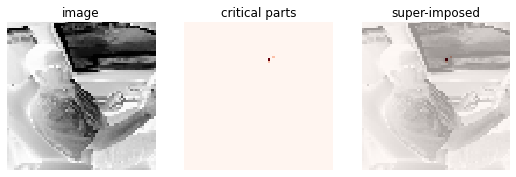

  Proba:
[ 0.      0.      0.      0.013   0.0071  0.8866  0.      0.0931  0.
  0.0001]
min Pby for cls: c5; desc: operating the radio; proba: 0.2829; nObs: 1
  img_91797.jpg:
  plot_occlusion:


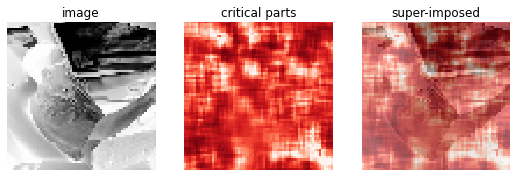

  Proba:
[ 0.0257  0.0457  0.008   0.15    0.1353  0.2829  0.0408  0.2654  0.0017
  0.0444]
  next best class: reaching behind


max Pby for cls: c6; desc: drinking; proba: 0.4756; nObs: 1
  img_73039.jpg:
  plot_occlusion:


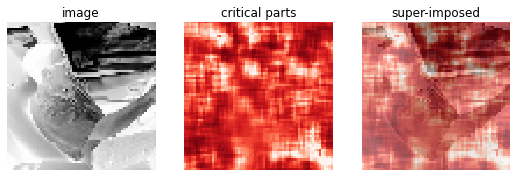

  Proba:
[ 0.0008  0.0374  0.4318  0.0005  0.0522  0.0002  0.4756  0.0005  0.0003
  0.0007]
min Pby for cls: c6; desc: drinking; proba: 0.4756; nObs: 1
  img_73039.jpg:
  plot_occlusion:


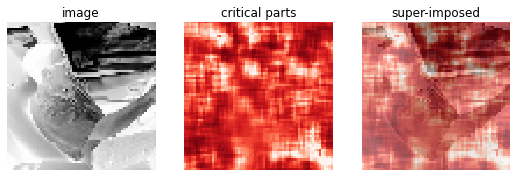

  Proba:
[ 0.0008  0.0374  0.4318  0.0005  0.0522  0.0002  0.4756  0.0005  0.0003
  0.0007]
  next best class: talking on the phone - right


max Pby for cls: c7; desc: reaching behind; proba: 1.0000; nObs: 1
  img_23350.jpg:
  plot_occlusion:


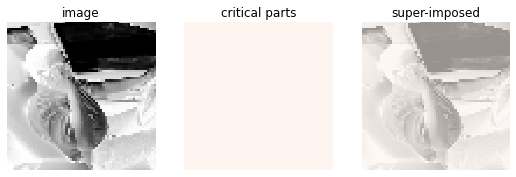

  Proba:
[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
min Pby for cls: c7; desc: reaching behind; proba: 0.1256; nObs: 1
  img_82894.jpg:
  plot_occlusion:


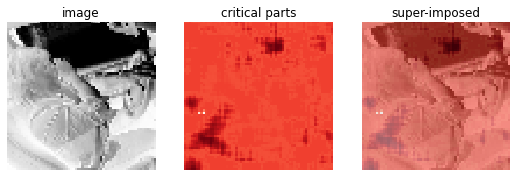

  Proba:
[ 0.0468  0.1116  0.1004  0.0823  0.0998  0.0936  0.1164  0.1256  0.125
  0.0985]
  next best class: hair and makeup


max Pby for cls: c8; desc: hair and makeup; proba: 1.0000; nObs: 1
  img_7407.jpg:
  plot_occlusion:


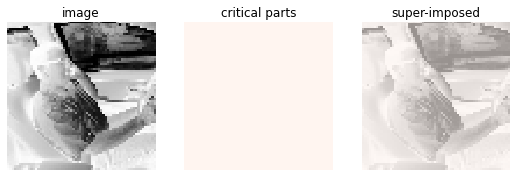

  Proba:
[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
min Pby for cls: c8; desc: hair and makeup; proba: 0.1323; nObs: 1
  img_3899.jpg:
  plot_occlusion:


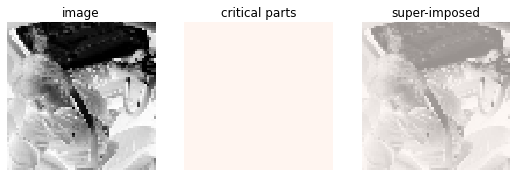

  Proba:
[ 0.0433  0.1114  0.0961  0.0796  0.0987  0.0957  0.1166  0.1249  0.1323
  0.1013]
  next best class: reaching behind


max Pby for cls: c9; desc: talking to passenger; proba: 0.4900; nObs: 1
  img_36711.jpg:
  plot_occlusion:


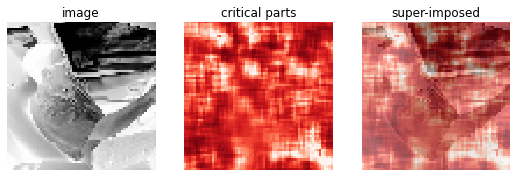

  Proba:
[ 0.      0.0061  0.0001  0.      0.0001  0.0424  0.      0.0018  0.4594
  0.49  ]
min Pby for cls: c9; desc: talking to passenger; proba: 0.4900; nObs: 1
  img_36711.jpg:
  plot_occlusion:


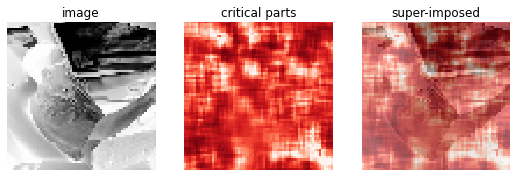

  Proba:
[ 0.      0.0061  0.0001  0.      0.0001  0.0424  0.      0.0018  0.4594
  0.49  ]
  next best class: hair and makeup
  duration: 46 seconds

Logistic Regression (TensorFlow): nObsFit:  100; nObsBtc:   16; rotatePby: 0.2000; rotateMaxAgl:  10; nRELUs:   128; nStepsTfw:   10; lrnRateTfw:0.5000 
  visualize: False; newObs: True; verbose: False
  predicting 79726 new obs...
  duration: 23 seconds

Logistic Regression (TensorFlow): nObsFit:  100; nObsBtc:   16; rotatePby: 0.2000; rotateMaxAgl:  10; nRELUs:   128; nStepsTfw:   10; lrnRateTfw:0.5000 
  visualize: False; newObs: False; verbose: True
('  tfwW1:', <tf.Tensor 'Identity:0' shape=(4096, 128) dtype=float32>)
('  tfwB1:', <tf.Tensor 'Identity_1:0' shape=(128,) dtype=float32>)
('  tfwW3:', <tf.Tensor 'Identity_2:0' shape=(128, 10) dtype=float32>)
('  tfwB3:', <tf.Tensor 'Identity_3:0' shape=(10,) dtype=float32>)
  Initialized
  step     1(    0 secs): Minibatch rotation:angle: 3.9074
  step     6(    0 secs): Minibatch rotat

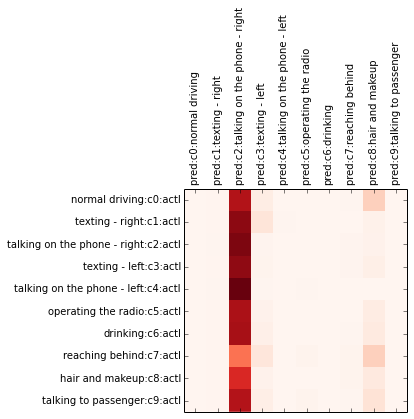


  Vld  logLoss:2.7317
[ 0.295   0.2562  0.2235  0.2323  0.2393  0.2725  0.2714  0.3345  0.1999
  0.4071]
  duration: 01 seconds

Logistic Regression (TensorFlow): nObsFit:  100; nObsBtc:   16; rotatePby: 0.2000; rotateMaxAgl:  10; nRELUs:   128; nStepsTfw:   10; lrnRateTfw:0.5000 
  visualize: False; newObs: False; verbose: False
  duration: 01 seconds

tmpMdlDf: 
     accVld                                          accVldCls  duration  \
0  0.110651  {u'accCls': [0.0, 0.0, 0.96017699115, 0.015801...        46   
0  0.110651  {u'accCls': [0.0, 0.0, 0.96017699115, 0.015801...        23   
0  0.110651  {u'accCls': [0.0, 0.0, 0.96017699115, 0.015801...         1   
0  0.110651  {u'accCls': [0.0, 0.0, 0.96017699115, 0.015801...         1   

            id  logLossVld                                      logLossVldCls  \
0  MLP.SGD.tfw    2.731677  {u'logLossCls': [0.294985288628, 0.25619677152...   
0  MLP.SGD.tfw    2.731677  {u'logLossCls': [0.294985288628, 0.25619677152...   
0  MLP.S

In [9]:
%run img_glbSpec_SFDD_ImgSz_64.py
%run img_utils.py

# Add parameter for lrnRateTfw = 0.5 for GradientDescentOptimizer

def fitMdlMLPRELUSGDTfw(lclXFit, lclYFit, 
            nObsFit = 100, nObsBtc = 16, 
            rotatePby = 0.1, rotateMaxAgl = 5,
            nRELUs = 128,            
            nStepsTfw = 10, lrnRateTfw = 0.1,
                    visualize = False, newObs = False, verbose = False):
    
    from scipy.ndimage import rotate    
    from sklearn import metrics as skl_metrics
    
    prtStr = '\nLogistic Regression (TensorFlow): ' + \
          "nObsFit:%5d; nObsBtc:%5d; " + \
          "rotatePby: %.4f; rotateMaxAgl: %3d; " + \
          "nRELUs: %5d; " + \
          "nStepsTfw:%5d; lrnRateTfw:%.4f "
    print(prtStr % ( \
            nObsFit, nObsBtc, \
            rotatePby, rotateMaxAgl, \
            nRELUs, \
            nStepsTfw, lrnRateTfw))
    print("  visualize: %s; newObs: %s; verbose: %s" % ( \
            visualize, newObs, verbose))
    
    # Ensure each Fit obs used at least once during training
    if (nStepsTfw * nObsBtc < nObsFit):
        print "  nStepsTfw * nObsBtc < nObsFit: %5d < %5d" % (\
                    nStepsTfw * nObsBtc, nObsFit)
        nStepsTfw = int(nObsFit / nObsBtc + 1) 
        print "  overriding nStepsTfw: %5d" % (nStepsTfw)
    
    startTm = datetime.now()

    mdlDf = pd.DataFrame({'id': 'MLP.SGD.tfw',
                             'nObsFit': [nObsFit],
                             'nObsBtc': [nObsBtc],
                           'rotatePby': [rotatePby],
                        'rotateMaxAgl': [rotateMaxAgl],
                              'nRELUs': [nRELUs],                          
                           'nStepsTfw': [nStepsTfw],
                          'lrnRateTfw': [lrnRateTfw]
                         })
    
    graph = tf.Graph()
    with graph.as_default():

      # Input data.
      # The training data, we use a placeholder that will be fed
      #   at run time with a training minibatch.
      # The validation data into constants that 
      #  are attached to the graph.
      # The tests data is loaded by batch thru a placeholder
#       tfwXFit = tf.constant(lclXFit[:nObsFit, :])
#       tfwYFit = tf.constant(lclYFit[:nObsFit])
      tfwXFit = tf.placeholder(tf.float32,
                    shape = (nObsBtc, lclXFit.shape[1]))
      tfwYFit = tf.placeholder(tf.float32, 
                    shape = (nObsBtc, lclYFit.shape[1]))
      tfwXVld = tf.constant(glbXVld)
      tfwYVld = tf.constant(glbYVld)   
      tfwXNew = tf.placeholder(tf.float32, 
                    shape = (glbImg['size'], lclXFit.shape[1]))
      tfwYNew = tf.placeholder(tf.float32, 
                    shape = (glbImg['size'], lclYFit.shape[1]))

      # Variables.
      tf.set_random_seed(glbTfwVarSeed)
    
      # These are the parameters that we are going to be training. 
      # The weight matrix will be initialized using random valued 
      # following a (truncated) normal distribution. 
      # The bias vector get initialized to zero.
      tfwW1 = tf.Variable(
        tf.truncated_normal([glbImg['size'] * glbImg['size'], 
                             nRELUs]), 
        name = 'tfwW1')
      tfwB1 = tf.Variable(tf.zeros([nRELUs]), name = 'tfwB1')
      tfwW3 = tf.Variable(
        tf.truncated_normal([nRELUs, 
                             glbRspClassN]), 
        name = 'tfwW3')
      tfwB3 = tf.Variable(tf.zeros([glbRspClassN]), name = 'tfwB3')
      if (verbose):  
          print('  tfwW1:', tfwW1.initialized_value())
          print('  tfwB1:', tfwB1.initialized_value())
          print('  tfwW3:', tfwW3.initialized_value())
          print('  tfwB3:', tfwB3.initialized_value())
#         print 'lblIx:%2d:%s'% \
#     (np.vectorize("%.4e".__mod__)(tfwW.value()[:5, lblIx]))

      def model(X):
          lyr1 = tf.matmul(X, tfwW1) + tfwB1
          lyr2 = tf.nn.relu(lyr1)
          YLgt = tf.matmul(lyr2, tfwW3) + tfwB3
          return(YLgt)

      # Training computation.
      # We multiply the inputs with the weight matrix, and add bias. 
      # We compute the softmax and cross-entropy (it's one operation in
      # TensorFlow, because it's very common, and it can be optimized). 
      # We take the average of this cross-entropy across all training 
      # examples: that's our loss.
      logits = model(tfwXFit)
      loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits, tfwYFit))

      # Optimizer.
      # We are going to find the minimum of this loss using 
      #  gradient descent.
      optimizer = (tf.train
                   .GradientDescentOptimizer(tf.to_float(lrnRateTfw))
                   .minimize(loss))

      # Predictions for the training, validation, and test data.
      # These are not part of training, but merely here so that we can
      # report accuracy_score figures as we train.
      tfwYFitPby = tf.nn.softmax(logits)
      tfwYVldPby = tf.nn.softmax(model(tfwXVld))
      tfwYNewPby = tf.nn.softmax(model(tfwXNew))
    
    def accuracy_score(predictions, labels):
      return (1.0 * np.sum(np.argmax(predictions, 1) == 
                           np.argmax(labels, 1))
              / predictions.shape[0])

    tf.set_random_seed(glbTfwVarSeed)
    # For image rotation in feed_dict. Separate seed to ensure 
    #   deterministic performance by tf session irrespective of 
    #   rotation randomization
    np.random.seed(glbNPySeed) 
    with tf.Session(graph=graph) as session:
      # This is a one-time operation which ensures the parameters get
      # initialized as we described in the graph: 
      # random tfwW for the matrix, zeros for the tfwB. 
      tf.initialize_all_variables().run()
      if verbose:
          print('  Initialized')
        
      # Create a dummy feed for test data & occlusion visualization
#       btcNewDct = {tfwXNew: glbXNew[:glbImg['size'], :]}
      for step in range(int(nStepsTfw)):
        
        # Pick an offset within the training data, which has been 
        #   randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * nObsBtc) % (nObsFit - nObsBtc)
        # Generate a minibatch (w/ or w/o rotation)
        if (np.random.rand() > rotatePby):
            btcXFit = lclXFit[offset:(offset + nObsBtc), :]
        else:
            rawXFit = np.reshape(lclXFit[offset:(offset + nObsBtc), :],
                            (nObsBtc, glbImg['size'], glbImg['size']))
            rttXFit = np.zeros_like(rawXFit)
            angle = (np.random.rand() - 0.5) * 2 * rotateMaxAgl
            if (verbose): 
                prtStr = '  step %5d(%5d secs): Minibatch rotation:' + \
                         "angle: %.4f"
                print(prtStr % \
                    (step, thsDrn, \
                     angle))            
#             print '  rawXFit.shape: %s' % (str(rawXFit.shape))
            for ix in xrange(rawXFit.shape[0]):                
#                 if (ix % 10 == 0): 
#                     print '    rawXFit[ix, :, :].shape: %s' % \
#                         (str(rawXFit[ix, :, :].shape))                
                rttXFit[ix, :, :] = rotate(rawXFit[ix, :, :], angle, 
                                        mode = 'nearest', reshape = False)
            btcXFit = np.reshape(rttXFit, 
                        (nObsBtc, glbImg['size'] * glbImg['size']))
            
        btcYFit = lclYFit[offset:(offset + nObsBtc), :]
        
        # Prepare a dictionary telling the session where to feed the 
        #   minibatch. The key of the dictionary is the placeholder node
        #   of the graph to be fed, and the value is the numpy array to 
        #   feed to it.
        feed_dict = {tfwXFit: btcXFit, tfwYFit: btcYFit,
                     tfwXNew: glbXNew[:glbImg['size'], :]}        
        
        # Run the computations. 
        # We tell .run() that we want to run the optimizer,
        # and get the loss value and the training predictions returned
        # as numpy arrays.
        _, l, predictions = \
            session.run([optimizer, loss, tfwYFitPby], 
                        feed_dict = feed_dict)
            
        if mydspVerboseTrigger(step):
          thsDrn = (datetime.now() - startTm).seconds  
          if (thsDrn > 100):
              prtStr = '  step %5d(%5d secs): Minibatch ' + \
                        "accuracy: %.4f; logloss: %.4f"  
              print(prtStr % \
                    (step, thsDrn, 
                     accuracy_score(predictions, btcYFit), l))
        
      # Calling .eval() on tfwObsVldPred is basically like calling run(), 
      # but just to get that one numpy array. 
      # Note that it recomputes all its graph dependencies.
    
      lclYVldPby = tfwYVldPby.eval()
      lclYVldPdn = np.argmax(lclYVldPby, 1)
      mdlDf['accVld'] = accVld = accuracy_score(lclYVldPby, glbYVld)
      cnfYVld = skl_metrics.confusion_matrix(glbObsVldRsp, lclYVldPdn)
      accYVldCls = cnfYVld.diagonal() * 1.0 / cnfYVld.sum(axis = 1)
      mdlDf['accVldCls'] = None
      mdlDf.set_value(0, 'accVldCls', {'accCls' : accYVldCls})
    
      mdlDf['logLossVld'] = logLossVld = skl_metrics.log_loss(
                                                glbYVld, lclYVldPby)
      logLossVldCls = mygetMetricLogLoss(glbYVld, lclYVldPby, 
                                         returnTyp = 'class')
      mdlDf['logLossVldCls'] = None
      mdlDf.set_value(0, 'logLossVldCls', 
                      {'logLossCls' : logLossVldCls})

      if verbose:
        print '\n  Vld accuracy:%0.4f' % (accVld)
        print accYVldCls
        print cnfYVld
        yLbl = [glbRspClassDesc[glbRspClass[ix]] + ':' + \
                  glbRspClass[ix] + ':actl' \
                for ix in xrange(glbRspClassN)]
        xLbl = ['pred:' + glbRspClass[ix] + ':' + \
                glbRspClassDesc[glbRspClass[ix]] \
                   for ix in xrange(glbRspClassN)]
        # print labels
        plt.matshow(cnfYVld, cmap='Reds', interpolation='none')
        plt.yticks(np.arange(10), yLbl)
        plt.xticks(np.arange(10), xLbl, rotation=90);
        plt.show()

        print '\n  Vld  logLoss:%0.4f' % (logLossVld)
        print logLossVldCls

      if visualize:
        mydisplayImagePredictions(session, tfwW1.eval(),
                glbIVld, glbObsVldFtr, glbObsVldRsp, lclYVldPby, 
                glbRspClass, glbRspClassDesc, imgVisualFn = plot_occlusion, 
                            tfwXOcc = tfwXNew, tfwYOccPby = tfwYNewPby)    
            
      if newObs:
          print "  predicting %5d new obs..." % (glbYNew.shape[0])  
          lclYNewPby = np.zeros((glbYNew.shape[0], 
                                 tfwYFitPby.get_shape().as_list()[1]))
          lclYNewPby[:, :] = -1.0
          btcSz = tfwXNew.get_shape().as_list()[0]  
          for obsIx in xrange(0, glbYNew.shape[0], btcSz):
            if mydspVerboseTrigger(obsIx) and \
              (datetime.now() - startTm).seconds > 60:
                print "    @%5d secs: obsIx: %5d" % \
                    ((datetime.now() - startTm).seconds, obsIx)    
            obsEnd = obsIx + btcSz
            if obsEnd > lclYNewPby.shape[0]: 
                obsEnd = lclYNewPby.shape[0]                
            btcYNewPby = session.run(tfwYNewPby, 
                feed_dict = {tfwXNew: glbXNew[obsIx:obsEnd, :] \
                    if obsEnd != lclYNewPby.shape[0] \
                    else np.vstack((glbXNew[obsIx:obsEnd, :], 
                            glbXNew[0:((obsIx + btcSz) % obsEnd), :]))
                                })
            lclYNewPby[obsIx:obsEnd, :] = btcYNewPby[:, :] \
                                if obsEnd != lclYNewPby.shape[0] \
                                else btcYNewPby[:(obsEnd - obsIx), :]    
          
          assert (lclYNewPby[:, :] != -1.0).all(), \
            'some cells in lclYNewPby == -1.0'
#           lclYNewPdn      = tfwYNew.eval()            
#           lclYNewPby = tfwYNewPby.eval()
          lclYNewPdn = np.argmax(lclYNewPby, 1) 
          #if (tfwYNew.eval() > -1).any():
          if (len(np.unique(glbYNew, return_counts = True)[0]) > 1):        
              mdlDf['accNew'] = accNew = accuracy_score(lclYNewPby, 
                                                        glbYNew)
              mdlDf['logLossNew'] = logLossNew = skl_metrics.log_loss(
                                                glbYNew, lclYNewPby)    
              if verbose:      
                print '\n  New accuracy:%0.4f' % (accNew)
                print   '  New  logLoss:%0.4f' % (logLossNew)        
                print skl_metrics.confusion_matrix(glbObsNewRsp, 
                                                   lclYNewPdn)
                yLbl = [glbRspClassDesc[glbRspClass[ix]] + ':' + 
                          glbRspClass[ix] + ':actl' \
                        for ix in xrange(glbRspClassN)]
                xLbl = ['pred:' + glbRspClass[ix] + ':' + \
                        glbRspClassDesc[glbRspClass[ix]] \
                           for ix in xrange(glbRspClassN)]
                # print labels
                plt.matshow(skl_metrics.confusion_matrix(glbObsNewRsp, 
                                                         lclYNewPdn), 
                            cmap='Reds', interpolation='none')
                plt.yticks(np.arange(10), yLbl)
                plt.xticks(np.arange(10), xLbl, rotation=90);
                plt.show()
                
          if visualize:      
              mydisplayImagePredictions(session, tfwW1.eval(),
                glbINew, glbObsNewFtr, glbObsNewRsp, lclYNewPby, 
                glbRspClass, glbRspClassDesc, imgVisualFn = plot_occlusion, 
                        tfwXOcc = tfwXNew, tfwYOccPby = tfwYNewPby)    

          mdlDf['predNew'] = None
          mdlDf.set_value(0, 'predNew', {'kntCls' : np.unique(lclYNewPdn, 
                                            return_counts = True)})
          if verbose:
            print '\n  New prediction knts:'
            print mdlDf['predNew'][0]
            
      # indentation (6 spaces) determines scope of this
      #   before session.__exit__ & graph.__exit__        
      mdlDf['model'] = session 
    
    mdlDf['duration'] = (datetime.now() - startTm).seconds  
    print('  duration: %.2d seconds' % (mdlDf['duration'][0]))  
    
    if not newObs: lclYNewPby = None
    return(mdlDf, lclYVldPby, lclYNewPby)

tmpMdlDf = pd.DataFrame()

# thsMdlDf, thsYVldPby, thsYNewPby = fitMdlMLPRELUSGDTfw(
#     glbXFit, glbYFit, 
#     nObsFit = 100, nObsBtc = 16, 
#     rotatePby = 0.2, rotateMaxAgl = 10,
#     nRELUs = 128,    
#     nStepsTfw = 10, lrnRateTfw = 0.5,
#     visualize = True, newObs = True, verbose = True)
# tmpMdlDf = tmpMdlDf.append(thsMdlDf)

# To check if model results are deterministic & 
# all run options work separately
thsMdlDf, thsYVldPby, thsYNewPby = fitMdlMLPRELUSGDTfw(
    glbXFit, glbYFit, 
    nObsFit = 100, nObsBtc = 16, 
    rotatePby = 0.2, rotateMaxAgl = 10, 
    nRELUs = 128,
    nStepsTfw = 10, lrnRateTfw = 0.5, 
    visualize = True, newObs = False, verbose = False)
tmpMdlDf = tmpMdlDf.append(thsMdlDf)

thsMdlDf, thsYVldPby, thsYNewPby = fitMdlMLPRELUSGDTfw(
    glbXFit, glbYFit, 
    nObsFit = 100, nObsBtc = 16, 
    rotatePby = 0.2, rotateMaxAgl = 10,    
    nRELUs = 128,    
    nStepsTfw = 10, lrnRateTfw = 0.5, 
    visualize = False, newObs = True, verbose = False)
tmpMdlDf = tmpMdlDf.append(thsMdlDf)

thsMdlDf, thsYVldPby, thsYNewPby = fitMdlMLPRELUSGDTfw(
    glbXFit, glbYFit, 
    nObsFit = 100, nObsBtc = 16, 
    rotatePby = 0.2, rotateMaxAgl = 10,    
    nRELUs = 128,    
    nStepsTfw = 10, lrnRateTfw = 0.5, 
    visualize = False, newObs = False, verbose = True)
tmpMdlDf = tmpMdlDf.append(thsMdlDf)

thsMdlDf, thsYVldPby, thsYNewPby = fitMdlMLPRELUSGDTfw(
    glbXFit, glbYFit, 
    nObsFit = 100, nObsBtc = 16, 
    rotatePby = 0.2, rotateMaxAgl = 10,
    nRELUs = 128,    
    nStepsTfw = 10, lrnRateTfw = 0.5,
    visualize = False, newObs = False, verbose = False)
tmpMdlDf = tmpMdlDf.append(thsMdlDf)

print '\ntmpMdlDf: '
print(tmpMdlDf)

In [10]:
# glbMdlDf = None
# glbMdlDf = pd.DataFrame()

try:
    with open(glbPickleFile['models'], 'rb') as f:
        glbMdlDf = pickle.load(f)
        assert isinstance(glbMdlDf, pd.DataFrame), \
            'type(glbMdlDf): %s, expecting pd.DataFrame' % \
            (str(type(glbMdlDf)))            
except IOError, e:
    print e
    print 'file %s not present or not appropriate' % \
        (glbPickleFile['models'])        
print glbMdlDf

                                                                                     accVld  \
id             nStepsTfw nObsFit nRELUs rotatePby nObsBtc lrnRateTfw rotateMaxAgl             
LgtRgr.skl     -1.0      22424.0 0      0.0       22424.0 -1.00      0             1.000000   
LgtRgr.tfw      1000.0   22424.0 0      0.0       22424.0  10.00     0             0.987348   
LgtRgr.SGD.tfw  2804.0   22424.0 0      0.1       8.0      3.00      2             0.833218   
                1000.0   18077.0 0      0.1       8.0      3.00      2             0.381643   
LgtRgr.tfw      1000.0   18077.0 0      0.0       18077.0  10.00     0             0.375201   
LgtRgr.SGD.tfw  1000.0   18077.0 0      0.1       8.0      1.00      2             0.361859   
                                                           2.00      1             0.357488   
                                        0.0       8.0      3.00      0             0.357028   
                                                  

In [11]:
%run img_utils.py
srchParamsDct = {
    'nObsFit' : [1000, 5000, 10000, glbObsFitFtr.shape[0]],
#     'nObsFit' : [1000, 5000, 6000, 7000, 8000, 9000, 10000, 
#                     glbObsFitFtr.shape[0], glbObsTrnFtr.shape[0]]
    'nObsBtc' : [8],    
#     'nObsBtc' : [4, 8, 16, 32],        
    'rotatePby' : [0.1],
#     'rotatePby' : [0.0, 0.1, 0.2, 0.5],    
    'rotateMaxAgl' : [2],
#     'rotateMaxAgl' : [0, 1, 10],    
    'nRELUs' : [512],
#     'nRELUs' : [16, 32, 64, 128, 256, 512, 1024],    
    'nStepsTfw' : [2260],
#     'nStepsTfw' : [100, 1000, 
#                    1130 (min. for nObsBtc = 16),     
#                    2260 (min. for nObsBtc = 8), 
#                    4520 (min. for nObsBtc = 4),     
#                    10000],    
    'lrnRateTfw' : [0.01]
#     'lrnRateTfw' : [0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 7.0, 10.0]    
                }

jnk = mysearchParams(fitMdlMLPRELUSGDTfw, srchParamsDct = srchParamsDct,
                     curResultsDf = glbMdlDf, 
               mode = 'displayonly', 
        sort_values    = ['nObsFit', 'accVld', 'logLossVld', 'duration'],
        sort_ascending = [False    , True    , False,        False],
                save_drop_cols = 'model',     
                save_filepathname = glbPickleFile['models'],
              lclXFit = glbXFit, lclYFit = glbYFit) 

# thsDf, thsObsVldRspPredProba, thsObsNewRspPredProba = fitMdlLgtRgrTfw(
#     glbXFit, glbYFit, 
#     nObsFit = 100, nStepsTfw = 10, lrnRateTfw = 0.5,
#     visualize = False, newObs = False, verbose = False)

mysearchParams: will run <function fitMdlMLPRELUSGDTfw at 0x10e0d20c8> with params:
Empty DataFrame
Columns: [nStepsTfw, nObsFit, nRELUs, rotatePby, nObsBtc, lrnRateTfw, rotateMaxAgl]
Index: []
mysearchParams: total runs: 0


In [19]:
%run img_utils.py

glbMdlDf = mysearchParams(fitMdlMLPRELUSGDTfw, srchParamsDct = srchParamsDct,
                     curResultsDf = glbMdlDf, 
               mode = 'run', 
        sort_values    = ['nObsFit', 'accVld', 'logLossVld', 'duration'],
        sort_ascending = [False    , False    , True,        True],       
                save_filepathname = glbPickleFile['models'],
                save_drop_cols = 'model',          
              lclXFit = glbXFit, lclYFit = glbYFit)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:143: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:162: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:145: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


mysearchParams: running <function fitMdlMLPRELUSGDTfw at 0x112ace0c8> with params:
nStepsTfw       2260
nObsFit         1000
nRELUs           512
rotatePby        0.1
nObsBtc            8
lrnRateTfw      0.01
rotateMaxAgl       2

Logistic Regression (TensorFlow): nObsFit: 1000; nObsBtc:    8; rotatePby: 0.1000; rotateMaxAgl:   2; nRELUs:   512; nStepsTfw: 2260; lrnRateTfw:0.0100 
  visualize: False; newObs: False; verbose: False
  duration: 54 seconds
mysearchParams: running <function fitMdlMLPRELUSGDTfw at 0x112ace0c8> with params:
nStepsTfw       2260
nObsFit         5000
nRELUs           512
rotatePby        0.1
nObsBtc            8
lrnRateTfw      0.01
rotateMaxAgl       2

Logistic Regression (TensorFlow): nObsFit: 5000; nObsBtc:    8; rotatePby: 0.1000; rotateMaxAgl:   2; nRELUs:   512; nStepsTfw: 2260; lrnRateTfw:0.0100 
  visualize: False; newObs: False; verbose: False
  duration: 54 seconds
mysearchParams: running <function fitMdlMLPRELUSGDTfw at 0x112ace0c8> with params:
nSt

In [12]:
glbMdlDf['bestFit'] = False
glbMdlDf.ix[(
 'LgtRgr.SGD.tfw', 1000.0,    18077.0, 0,      0.1,       8.0,     3.0,        2), 
# LgtRgr.SGD.tfw   1000.0     18077.0  0,      0.1        8.0      3.0         2            
# id               nStepsTfw  nObsFit  nRELUs, rotatePby  nObsBtc  lrnRateTfw  rotateMaxAgl
            'bestFit'] = True            
print glbMdlDf[glbMdlDf['bestFit']]
print glbMdlDf[['accVld', 'bestFit', 'id']].head().to_string(index = False)
# print glbMdlDf[glbMdlDf.nObsFit >= 10000][
#     list(set(glbMdlDf.columns) - set(srchParamsDct.keys()))]

                                                                                     accVld  \
id             nStepsTfw nObsFit nRELUs rotatePby nObsBtc lrnRateTfw rotateMaxAgl             
LgtRgr.SGD.tfw 1000.0    18077.0 0      0.1       8.0     3.0        2             0.381643   

                                                                                                                           accVldCls  \
id             nStepsTfw nObsFit nRELUs rotatePby nObsBtc lrnRateTfw rotateMaxAgl                                                      
LgtRgr.SGD.tfw 1000.0    18077.0 0      0.1       8.0     3.0        2             {u'accCls': [0.607438016529, 0.219665271967, 0...   

                                                                                  bestFit  \
id             nStepsTfw nObsFit nRELUs rotatePby nObsBtc lrnRateTfw rotateMaxAgl           
LgtRgr.SGD.tfw 1000.0    18077.0 0      0.1       8.0     3.0        2               True   

                         

/usr/local/lib/python2.7/site-packages/ipykernel/kernelbase.py:212: PerformanceWarning: indexing past lexsort depth may impact performance.
  handler(stream, idents, msg)


In [13]:
mask = glbMdlDf['bestFit'].values | \
       glbMdlDf['id'].str.contains('MLP.SGD.tfw', na = False).values
print glbMdlDf[mask]['accVld']

id              nStepsTfw  nObsFit  nRELUs  rotatePby  nObsBtc  lrnRateTfw  rotateMaxAgl
LgtRgr.SGD.tfw  1000.0     18077.0  0       0.1        8.0      3.000       2               0.381643
MLP.SGD.tfw     2260.0     18077.0  512     0.1        8.0      0.010       2               0.335864
                10000.0    18077.0  512     0.1        8.0      0.010       2               0.333793
                2260.0     18077.0  512     0.1        16.0     0.010       1               0.326202
                                                                0.009       1               0.315160
                                            0.2        16.0     0.010       1               0.311939
                                            0.1        16.0     0.009       2               0.311939
                5000.0     18077.0  512     0.1        8.0      0.010       2               0.311249
                2260.0     18077.0  512     0.2        16.0     0.009       3               0.311019
  

In [23]:
# Set value based on condition

# print glbMdlDf.ix[glbMdlDf['id'].str.contains('LogisticRegression.SGD.tf', 
#                                               na=False), 'id']
# glbMdlDf.ix[glbMdlDf['id'].str.contains('LogisticRegression.SGD.tf', 
#                                               na=False), 'id'] = 'LgtRgr.SGD.tf'
# print glbMdlDf.ix[glbMdlDf['id'].str.contains('LogisticRegression.SGD.tf', 
#                                               na=False), 'id']

def lclfixNanDf(df, column, default):
    print "\n Before:"
    dspDf = df[[column]]
    dspDf[column + '.isnull'] = df[column].isnull()
    print dspDf.to_string(index = False)
    
    df.loc[df[column].isnull(), column] = default
    
    print "\n After:"
    dspDf = df[[column]]
    dspDf[column + '.isnull'] = df[column].isnull()
    print dspDf.to_string(index = False)    
    return(df)

# tmpMdlDf = lclfixNanDf(glbMdlDf, column = 'nRELUs', default = 0)

# print glbMdlDf.ix[- glbMdlDf['nStepsTfw'].isnull(), ['id', 'nStepsTfw']]
# glbMdlDf.ix[- glbMdlDf['nStepsTfw'].isnull(), 'id'] = 'LogisticRegression.tf'
# print glbMdlDf.ix[- glbMdlDf['nStepsTfw'].isnull(), ['id', 'nStepsTfw']]

# print glbMdlDf.ix[glbMdlDf['nObsBtc'].isnull(), ['nObsBtc', 'nObsFit']]
# # glbMdlDf.ix[glbMdlDf['nObsBtc'].isnull(), 'nObsBtc'] = \
# #     glbMdlDf.ix[glbMdlDf['nObsBtc'].isnull(), 'nObsFit']
# glbMdlDf['nObsBtc'] = glbMdlDf.apply(
#     lambda (row): row['nObsFit'] if pd.isnull(row['nObsBtc']) else row['nObsBtc'],
#                         axis = 1)
# print 'After:'    
# print glbMdlDf.ix[glbMdlDf['nObsBtc'].isnull(), ['nObsBtc', 'nObsFit']]

# Change value
# tmpMdlDf = glbMdlDf
# print tmpMdlDf[(tmpMdlDf['id'].str.contains('LgtRgr.skl', na = False)) & 
#                (tmpMdlDf['nStepsTfw'] == 1.0)]
# print tmpMdlDf.ix[(tmpMdlDf['id'].str.contains('LgtRgr.skl', na = False)) & 
#                   (tmpMdlDf['nStepsTfw'] == 1.0), 'nStepsTfw']
# tmpMdlDf.ix[(tmpMdlDf['id'].str.contains('LgtRgr.skl', na = False)) & 
#                   (tmpMdlDf['nStepsTfw'] == 1.0), 'nStepsTfw'] = -1.0
# print 'After:'
# print tmpMdlDf

# Remove specific models
# mask = (glbMdlDf['id'].str.contains('MLP.SGD.tfw', na = False))
# mask = (glbMdlDf['id'].str.contains('LgtRgr.tfw', na = False)) & \
#        (glbMdlDf['nObsFit'] == 10000.0)
# print mask
# tmpMdlDf = glbMdlDf[~mask]
# print tmpMdlDf.to_string(index = False)

# Remove dups
print glbMdlDf.columns
# print (glbMdlDf['logLossVld'])
print (glbMdlDf.index.duplicated())
tmpMdlDf = glbMdlDf[~glbMdlDf.index.duplicated()]
print (tmpMdlDf.index.duplicated())

# glbMdlDf['nObsBtc'] = glbMdlDf['nObsFit'] 

# glbMdlDf = tmpMdlDf
# print 'After:'
# print glbMdlDf.to_string(index = False)
# print glbMdlDf['bestFit']

Index([u'accVld', u'accVldCls', u'bestFit', u'duration', u'id', u'logLossVld',
       u'logLossVldCls', u'lrnRateTfw', u'model', u'nObsBtc', u'nObsFit',
       u'nRELUs', u'nStepsTfw', u'predNew', u'rotateMaxAgl', u'rotatePby'],
      dtype='object')
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False 

In [57]:
glbMdlDf = glbMdlDf.set_index(['id'] + srchParamsDct.keys(), drop = False)
glbMdlDf = glbMdlDf.sort_values(['nObsFit', 'accVld', 'logLossVld', 'duration'], 
                     ascending = [False    , False    , True,        True])
print glbMdlDf.head()

                                                                                     accVld  \
id             nStepsTfw nObsFit nRELUs rotatePby nObsBtc lrnRateTfw rotateMaxAgl             
LgtRgr.skl     -1.0      22424.0 0      0.0       22424.0 -1.0       0             1.000000   
LgtRgr.tfw      1000.0   22424.0 0      0.0       22424.0  10.0      0             0.987348   
LgtRgr.SGD.tfw  2804.0   22424.0 0      0.1       8.0      3.0       2             0.833218   
                1000.0   18077.0 0      0.1       8.0      3.0       2             0.381643   
LgtRgr.tfw      1000.0   18077.0 0      0.0       18077.0  10.0      0             0.375201   

                                                                                                                           accVldCls  \
id             nStepsTfw nObsFit nRELUs rotatePby nObsBtc lrnRateTfw rotateMaxAgl                                                      
LgtRgr.skl     -1.0      22424.0 0      0.0       22424.0 -1.0

In [59]:
myexportDf(glbMdlDf, 
           save_filepathname = glbPickleFile['models'],
           save_drop_cols = 'model'
          )

Compressed pickle file: data/img_M_SFDD_ImgSz_64.pickle; size: 42 KB


In [25]:
robjects.pandas2ri.activate()
pltRDf = robjects.conversion.py2ri(glbMdlDf)
# print(pltRDf)
# pltRFn = robjects.r("""
#     source('~/Dropbox/datascience/R/myplot.R')
#     function(RDf, filename) {
#         mypltModelStats(RDf, c('accVld', 'logLossVld', 'duration'), 
#             dim = c('nObsFit', 'id', 
#                     'nRELUs', 
#                     'nObsBtc', 'rotatePby', 'rotateMaxAgl',
#                     'nStepsTfw', 'lrnRateTfw'), 
#                 scaleXFn = NULL, 
#                 #highLightIx = which.min(RDf$logLossVld),
#                 highLightIx = which(RDf$bestFit == 'TRUE'),                
#             title = NULL, 
#             fileName = filename)
#     }                        
# """)    
# pltRFn(pltRDf, 'img_05_fit_MLP_RELU_SGD_Tfw_SFDD_glbMdlDf.png')

# pltRFn = robjects.r("""
#     source('~/Dropbox/datascience/R/myplot.R')
#     function(RDf, filename) {
#         mypltModelStats(RDf, c('accVld', 'logLossVld'), 
#             dim = c('nObsFit', 'id', 
#                     'nRELUs',
#                     'nObsBtc', 'rotatePby', 'rotateMaxAgl',
#                     'nStepsTfw', 'lrnRateTfw'), 
#                 scaleXFn = NULL, 
#                 #highLightIx = which.min(RDf$logLossVld),
#                 highLightIx = which(RDf$bestFit == 'TRUE'),                
#             title = NULL, 
#             fileName = filename)
#     }                        
# """)    
# pltRFn(pltRDf, 'img_05_fit_MLP_RELU_SGD_Tfw_SFDD_glbMdlDf_logLossVld.png')

# pltRFn = robjects.r("""
#     source('~/Dropbox/datascience/R/myplot.R')
#     function(RDf, filename) {
#         mypltModelStats(RDf, c('accVld'), 
#             dim = c('nObsFit', 'id', 
#                     'nRELUs',
#                     'nObsBtc', 'rotatePby', 'rotateMaxAgl',
#                     'nStepsTfw', 'lrnRateTfw'), 
#                 scaleXFn = NULL, 
#                 #highLightIx = which.min(RDf$logLossVld),
#                 highLightIx = which(RDf$bestFit == 'TRUE'),                
#             title = NULL, 
#             fileName = filename)
#     }                        
# """)    
# pltRFn(pltRDf, 'img_05_fit_MLP_RELU_SGD_Tfw_SFDD_glbMdlDf_accVld.png')

pltRFn = robjects.r("""
    source('~/Dropbox/datascience/R/myplot.R')
    function(RDf, filename) {
    pltRDf = rbind(NULL
                      , subset(RDf, id %in% c("LgtRgr.skl") &
                                   TRUE)
                      , subset(RDf, id %in% c("LgtRgr.tfw") &
                                   nStepsTfw %in% c(1000) &
                                   lrnRateTfw %in% c(10.0) &
                                   TRUE)
                      , subset(RDf, id %in% c("LgtRgr.SGD.tfw") &
                                   nStepsTfw %in% c(1000, 2804) &
                                   rotateMaxAgl %in% c(2) &
                                   lrnRateTfw %in% c(3) &
                                   nObsBtc %in% c(8) &
                                   rotatePby %in% c(0.1) &
                                   TRUE)
                      , subset(RDf, id %in% c("MLP.SGD.tfw") &
                                   rotateMaxAgl %in% c(2) &
                                   lrnRateTfw %in% c(0.01) &
                                   nObsBtc %in% c(8) &
                                   rotatePby %in% c(0.1) &
                                   nRELUs %in% c(512) &
                                   nStepsTfw %in% c(2260) &
                                   TRUE)
    )    
        mypltModelStats(pltRDf,
                measure = c('accVld'),
                dim = c('nObsFit', 'id',
                        'nRELUs',
                        'nStepsTfw',                        
                        # 'nObsBtc',
                        # 'lrnRateTfw',
                        # 'rotatePby',
                        # 'rotateMaxAgl',
                        NULL),        
                scaleXFn = NULL, 
                highLightIx = which(pltRDf$bestFit == 'TRUE'),                
            title = NULL, 
            fileName = filename)
    }                        
""")    
pltRFn(pltRDf, 'img_05_fit_MLP_RELU_SGD_Tfw_SFDD_glbMdlDf_accVldSel.png')

# id nStepsTfw  nObsFit  rotatePby  nObsBtc  lrnRateTfw  rotateMaxAgl

<ListVector - Python:0x146ae5a28 / R:0x7faa61b40b50>
[DataF..., ListV..., Envir..., ..., ListV..., Envir..., ListV...]
<ListVector - Python:0x146ae5a28 / R:0x7faa61b40b50>
[DataF..., ListV..., Envir..., ..., ListV..., Envir..., ListV...]
<ListVector - Python:0x146ae5a28 / R:0x7faa61b40b50>
[DataF..., ListV..., Envir..., ..., ListV..., Envir..., ListV...]
  scales: <class 'rpy2.robjects.environments.Environment'>
  <Environment - Python:0x146ae5e18 / R:0x7faa7b40b0b0>
  ...
<ListVector - Python:0x146ae5a28 / R:0x7faa61b40b50>
[DataF..., ListV..., Envir..., ..., ListV..., Envir..., ListV...]
  layers: <class 'rpy2.robjects.environments.Environment'>
  <Environment - Python:0x146ae3128 / R:0x7faa6f502fc0>
<ListVector - Python:0x146ae5a28 / R:0x7faa61b40b50>
[DataF..., ListV..., Envir..., ..., ListV..., Envir..., ListV...]

In [24]:
glbMdlDf.to_csv('img_05_fit_MLP_RELU_SGD_Tfw_SFDD_glbMdlDf.csv')

### Fit selected model to glbObsFit

In [14]:
# selMdlSrs = glbMdlDf[glbMdlDf['bestFit']]

mask = (glbMdlDf['id'].str.contains('MLP.SGD.tfw', na = False)) & \
       (glbMdlDf['accVld'] > 0.334)
selMdlSrs = glbMdlDf[mask]
print selMdlSrs

                                                                                  accVld  \
id          nStepsTfw nObsFit nRELUs rotatePby nObsBtc lrnRateTfw rotateMaxAgl             
MLP.SGD.tfw 2260.0    18077.0 512    0.1       8.0     0.01       2             0.335864   

                                                                                                                        accVldCls  \
id          nStepsTfw nObsFit nRELUs rotatePby nObsBtc lrnRateTfw rotateMaxAgl                                                      
MLP.SGD.tfw 2260.0    18077.0 512    0.1       8.0     0.01       2             {u'accCls': [0.576446280992, 0.278242677824, 0...   

                                                                               bestFit  \
id          nStepsTfw nObsFit nRELUs rotatePby nObsBtc lrnRateTfw rotateMaxAgl           
MLP.SGD.tfw 2260.0    18077.0 512    0.1       8.0     0.01       2              False   

                                                    


Logistic Regression (TensorFlow): nObsFit:18077; nObsBtc:    8; rotatePby: 0.1000; rotateMaxAgl:   2; nRELUs:   512; nStepsTfw: 2260; lrnRateTfw:0.0100 
  visualize: True; newObs: True; verbose: True
('  tfwW1:', <tf.Tensor 'Identity:0' shape=(4096, 512) dtype=float32>)
('  tfwB1:', <tf.Tensor 'Identity_1:0' shape=(512,) dtype=float32>)
('  tfwW3:', <tf.Tensor 'Identity_2:0' shape=(512, 10) dtype=float32>)
('  tfwB3:', <tf.Tensor 'Identity_3:0' shape=(10,) dtype=float32>)
  Initialized

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:143: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:162: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:145: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future



  step     1(    1 secs): Minibatch rotation:angle: 0.7815
  step     6(    1 secs): Minibatch rotation:angle: 1.3900
  step    13(    1 secs): Minibatch rotation:angle: 1.4487
  step    34(    1 secs): Minibatch rotation:angle: 0.2647
  step    39(    1 secs): Minibatch rotation:angle: -0.4238
  step    40(    1 secs): Minibatch rotation:angle: -1.0228
  step    42(    2 secs): Minibatch rotation:angle: -1.5997
  step    73(    2 secs): Minibatch rotation:angle: -1.4536
  step    75(    2 secs): Minibatch rotation:angle: 0.7455
  step    78(    2 secs): Minibatch rotation:angle: -0.2561
  step    86(    2 secs): Minibatch rotation:angle: 0.0559
  step    89(    2 secs): Minibatch rotation:angle: 0.8329
  step    93(    2 secs): Minibatch rotation:angle: 0.1879
  step   101(    2 secs): Minibatch rotation:angle: 0.1547
  step   123(    2 secs): Minibatch rotation:angle: 0.4447
  step   134(    2 secs): Minibatch rotation:angle: -1.7246
  step   139(    2 secs): Minibatch rotation:angl

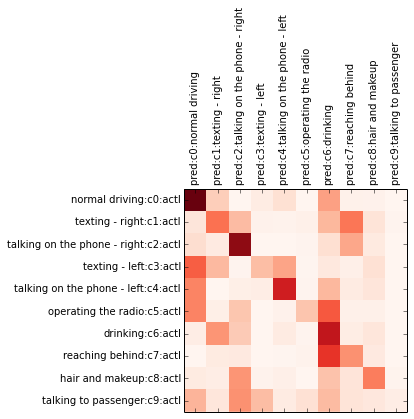


  Vld  logLoss:19.7827
[ 1.385   2.2396  1.113   2.6201  1.7168  2.6953  1.3689  1.7096  1.6075
  3.327 ]


max Pby for cls: c0; desc: normal driving; proba: 1.0000; nObs: 566
  img_62023.jpg:
  plot_occlusion:


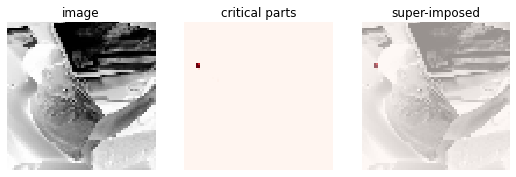

  Proba:
[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
min Pby for cls: c0; desc: normal driving; proba: 0.5036; nObs: 1
  img_37258.jpg:
  plot_occlusion:


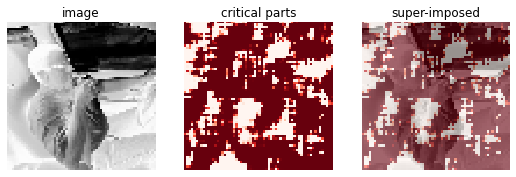

  Proba:
[ 0.5036  0.      0.      0.0001  0.4964  0.      0.      0.      0.      0.    ]
  next best class: talking on the phone - left


max Pby for cls: c1; desc: texting - right; proba: 1.0000; nObs: 278
  img_89322.jpg:
  plot_occlusion:


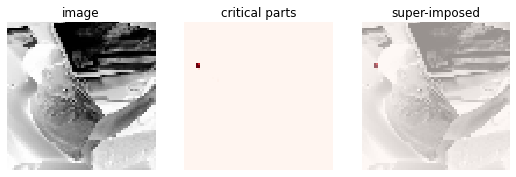

  Proba:
[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
min Pby for cls: c1; desc: texting - right; proba: 0.5267; nObs: 1
  img_95570.jpg:
  plot_occlusion:


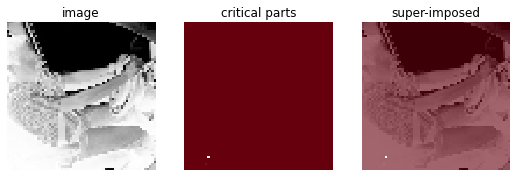

  Proba:
[ 0.      0.5267  0.      0.      0.      0.      0.4733  0.      0.      0.    ]
  next best class: drinking


max Pby for cls: c2; desc: talking on the phone - right; proba: 1.0000; nObs: 387
  img_29251.jpg:
  plot_occlusion:


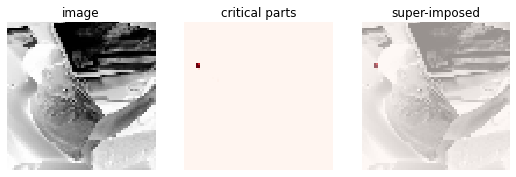

  Proba:
[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
min Pby for cls: c2; desc: talking on the phone - right; proba: 0.5025; nObs: 1
  img_20398.jpg:
  plot_occlusion:


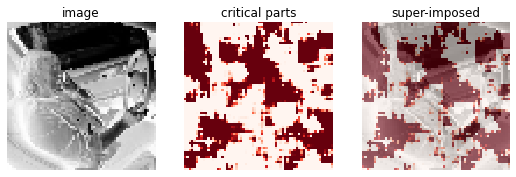

  Proba:
[ 0.      0.      0.5025  0.      0.      0.      0.      0.      0.4975
  0.    ]
  next best class: hair and makeup


max Pby for cls: c3; desc: texting - left; proba: 1.0000; nObs: 81
  img_71015.jpg:
  plot_occlusion:


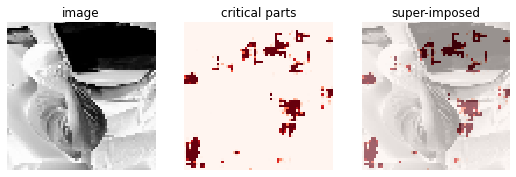

  Proba:
[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
min Pby for cls: c3; desc: texting - left; proba: 0.5222; nObs: 1
  img_494.jpg:
  plot_occlusion:


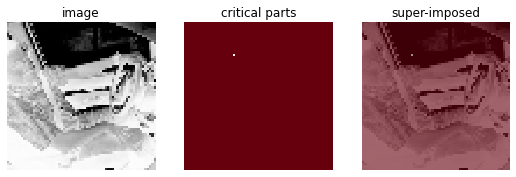

  Proba:
[ 0.4778  0.      0.      0.5222  0.      0.      0.      0.      0.      0.    ]
  next best class: normal driving


max Pby for cls: c4; desc: talking on the phone - left; proba: 1.0000; nObs: 231
  img_18343.jpg:
  plot_occlusion:


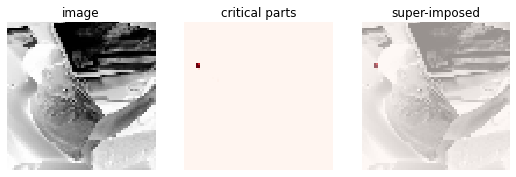

  Proba:
[ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
min Pby for cls: c4; desc: talking on the phone - left; proba: 0.5223; nObs: 1
  img_62576.jpg:
  plot_occlusion:


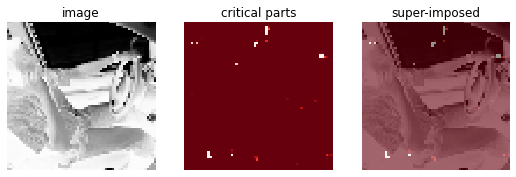

  Proba:
[ 0.0013  0.      0.      0.      0.5223  0.      0.4764  0.      0.      0.    ]
  next best class: drinking


max Pby for cls: c5; desc: operating the radio; proba: 1.0000; nObs: 69
  img_44922.jpg:
  plot_occlusion:


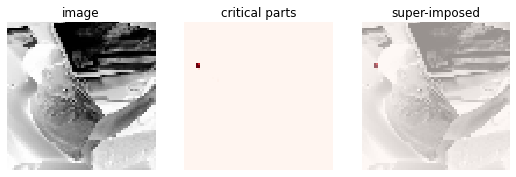

  Proba:
[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
min Pby for cls: c5; desc: operating the radio; proba: 0.4260; nObs: 1
  img_91452.jpg:
  plot_occlusion:


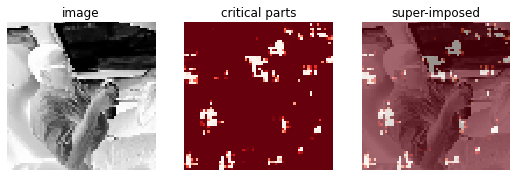

  Proba:
[ 0.      0.      0.2523  0.      0.      0.426   0.0153  0.3064  0.      0.    ]
  next best class: reaching behind


max Pby for cls: c6; desc: drinking; proba: 1.0000; nObs: 645
  img_15827.jpg:
  plot_occlusion:


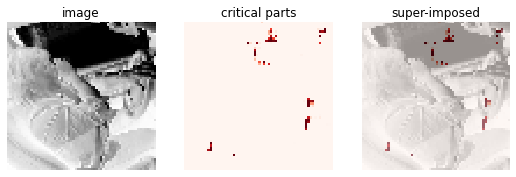

  Proba:
[ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
min Pby for cls: c6; desc: drinking; proba: 0.5227; nObs: 1
  img_36526.jpg:
  plot_occlusion:


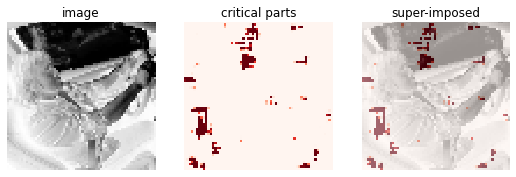

  Proba:
[ 0.4773  0.      0.      0.      0.      0.      0.5227  0.      0.      0.    ]
  next best class: normal driving


max Pby for cls: c7; desc: reaching behind; proba: 1.0000; nObs: 309
  img_101868.jpg:
  plot_occlusion:


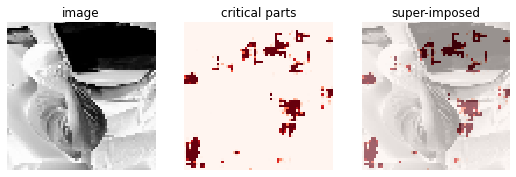

  Proba:
[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
min Pby for cls: c7; desc: reaching behind; proba: 0.5021; nObs: 1
  img_46643.jpg:
  plot_occlusion:


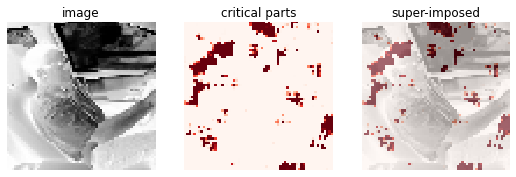

  Proba:
[ 0.      0.      0.      0.      0.0188  0.      0.4791  0.5021  0.      0.    ]
  next best class: drinking


max Pby for cls: c8; desc: hair and makeup; proba: 1.0000; nObs: 195
  img_78749.jpg:
  plot_occlusion:


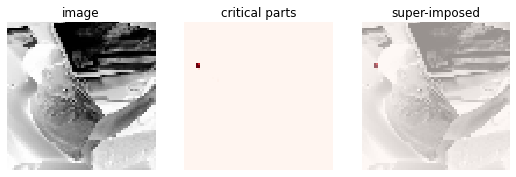

  Proba:
[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
min Pby for cls: c8; desc: hair and makeup; proba: 0.4652; nObs: 1
  img_84310.jpg:
  plot_occlusion:


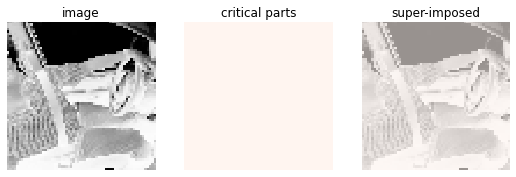

  Proba:
[ 0.      0.      0.      0.      0.      0.      0.1883  0.3464  0.4652
  0.    ]
  next best class: reaching behind


max Pby for cls: c9; desc: talking to passenger; proba: 1.0000; nObs: 9
  img_89106.jpg:
  plot_occlusion:


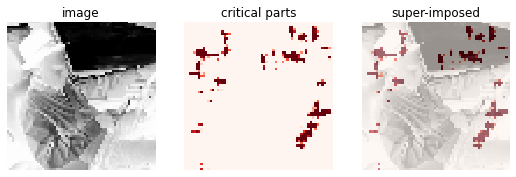

  Proba:
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
min Pby for cls: c9; desc: talking to passenger; proba: 0.8457; nObs: 1
  img_22899.jpg:
  plot_occlusion:


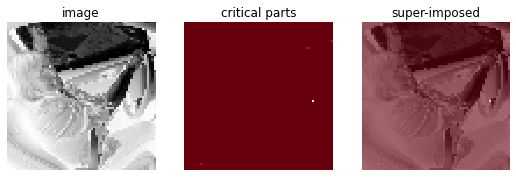

  Proba:
[ 0.      0.      0.      0.      0.      0.      0.      0.      0.1543
  0.8457]
  next best class: hair and makeup
  predicting 79726 new obs...
    @  112 secs: obsIx:     0
    @  115 secs: obsIx:  8000
    @  127 secs: obsIx: 40000


max Pby for cls: c0; desc: normal driving; proba: 1.0000; nObs: 6320
  img_100.jpg:
  plot_occlusion:


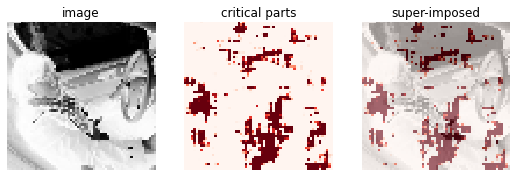

  Proba:
[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
min Pby for cls: c0; desc: normal driving; proba: 0.3896; nObs: 1
  img_26160.jpg:
  plot_occlusion:


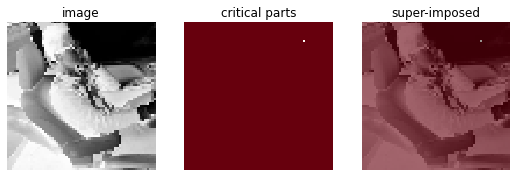

  Proba:
[ 0.3896  0.3109  0.      0.      0.      0.      0.      0.      0.
  0.2995]
  next best class: texting - right


max Pby for cls: c1; desc: texting - right; proba: 1.0000; nObs: 5049
  img_100010.jpg:
  plot_occlusion:


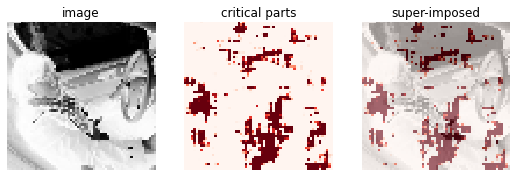

  Proba:
[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
min Pby for cls: c1; desc: texting - right; proba: 0.3658; nObs: 1
  img_87391.jpg:
  plot_occlusion:


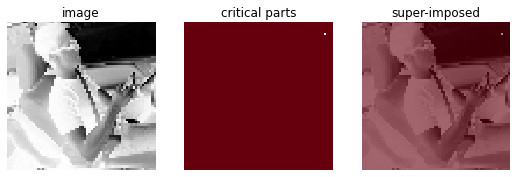

  Proba:
[ 0.      0.3658  0.      0.      0.3168  0.      0.      0.      0.
  0.3175]
  next best class: talking to passenger


max Pby for cls: c2; desc: talking on the phone - right; proba: 1.0000; nObs: 2355
  img_100017.jpg:
  plot_occlusion:


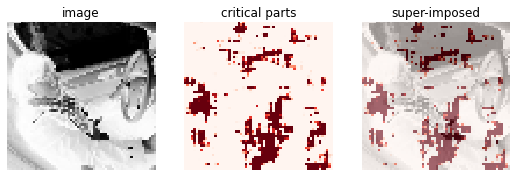

  Proba:
[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
min Pby for cls: c2; desc: talking on the phone - right; proba: 0.3595; nObs: 1
  img_47810.jpg:
  plot_occlusion:


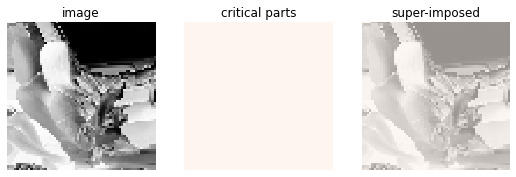

  Proba:
[ 0.3258  0.      0.3595  0.      0.      0.      0.      0.3147  0.      0.    ]
  next best class: normal driving


max Pby for cls: c3; desc: texting - left; proba: 1.0000; nObs: 3476
  img_100000.jpg:
  plot_occlusion:


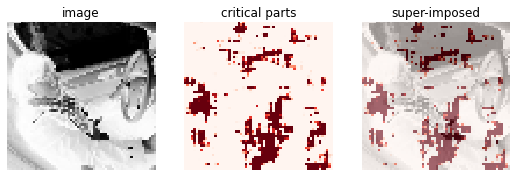

  Proba:
[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
min Pby for cls: c3; desc: texting - left; proba: 0.4649; nObs: 1
  img_59302.jpg:
  plot_occlusion:


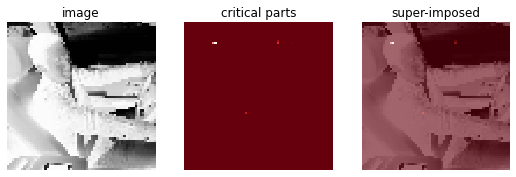

  Proba:
[ 0.2365  0.0001  0.      0.4649  0.2985  0.      0.      0.      0.      0.    ]
  next best class: talking on the phone - left


max Pby for cls: c4; desc: talking on the phone - left; proba: 1.0000; nObs: 7006
  img_100001.jpg:
  plot_occlusion:


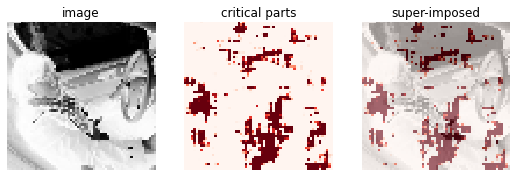

  Proba:
[ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
min Pby for cls: c4; desc: talking on the phone - left; proba: 0.4063; nObs: 1
  img_47762.jpg:
  plot_occlusion:


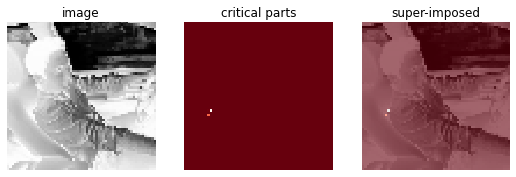

  Proba:
[ 0.      0.      0.      0.      0.4063  0.      0.2561  0.3375  0.      0.    ]
  next best class: reaching behind


max Pby for cls: c5; desc: operating the radio; proba: 1.0000; nObs: 4001
  img_10.jpg:
  plot_occlusion:


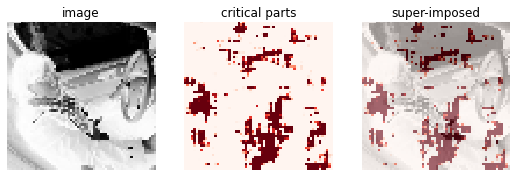

  Proba:
[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
min Pby for cls: c5; desc: operating the radio; proba: 0.5036; nObs: 1
  img_70083.jpg:
  plot_occlusion:


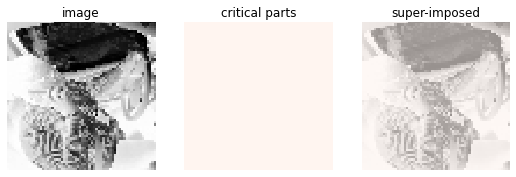

  Proba:
[ 0.      0.      0.      0.      0.      0.5036  0.      0.      0.4964
  0.    ]
  next best class: hair and makeup


max Pby for cls: c6; desc: drinking; proba: 1.0000; nObs: 9212
  img_100002.jpg:
  plot_occlusion:


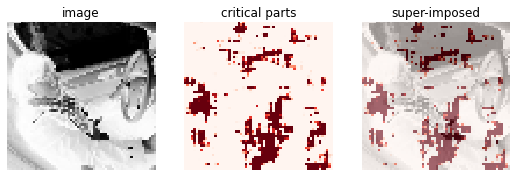

  Proba:
[ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
min Pby for cls: c6; desc: drinking; proba: 0.4571; nObs: 1
  img_31636.jpg:
  plot_occlusion:


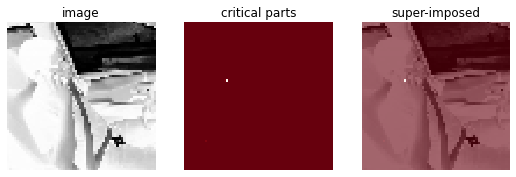

  Proba:
[ 0.      0.      0.      0.      0.      0.      0.4571  0.      0.2087
  0.3342]
  next best class: talking to passenger


max Pby for cls: c7; desc: reaching behind; proba: 1.0000; nObs: 9209
  img_100003.jpg:
  plot_occlusion:


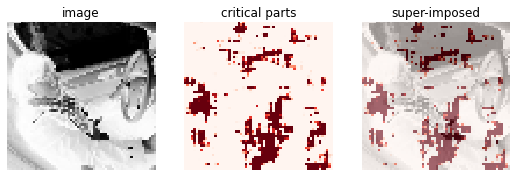

  Proba:
[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
min Pby for cls: c7; desc: reaching behind; proba: 0.4571; nObs: 1
  img_41180.jpg:
  plot_occlusion:


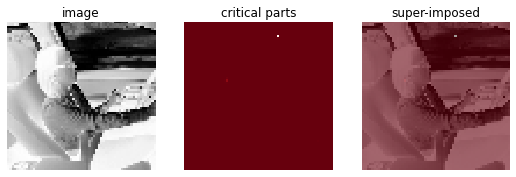

  Proba:
[ 0.1532  0.      0.      0.      0.      0.      0.      0.4571  0.3897
  0.    ]
  next best class: hair and makeup


max Pby for cls: c8; desc: hair and makeup; proba: 1.0000; nObs: 4555
  img_1000.jpg:
  plot_occlusion:


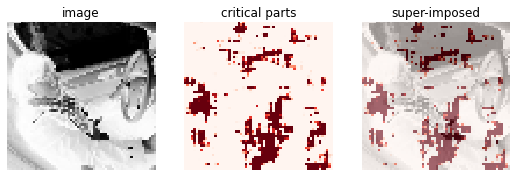

  Proba:
[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
min Pby for cls: c8; desc: hair and makeup; proba: 0.3791; nObs: 1
  img_22366.jpg:
  plot_occlusion:


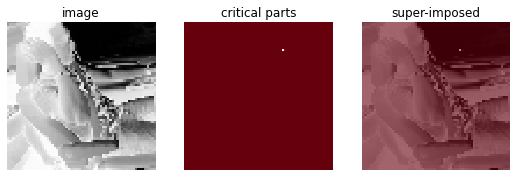

  Proba:
[ 0.      0.      0.      0.      0.      0.      0.3398  0.2811  0.3791
  0.    ]
  next best class: drinking


max Pby for cls: c9; desc: talking to passenger; proba: 1.0000; nObs: 3105
  img_1.jpg:
  plot_occlusion:


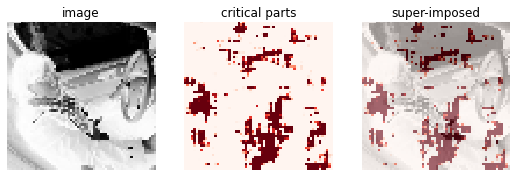

  Proba:
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
min Pby for cls: c9; desc: talking to passenger; proba: 0.5018; nObs: 1
  img_7457.jpg:
  plot_occlusion:


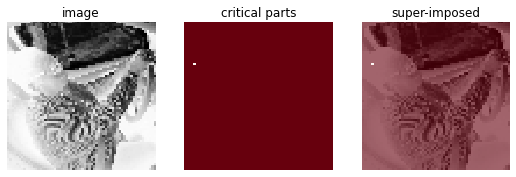

  Proba:
[ 0.      0.4982  0.      0.      0.      0.      0.      0.      0.
  0.5018]
  next best class: texting - right

  New prediction knts:
{'kntCls': (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([ 9474,  7927,  4263,  5212,  9992,  5709, 13403, 12009,  6954,  4783]))}
  duration: 190 seconds


In [31]:
selMdlDf, selYVldPby, selYNewPby = fitMdlMLPRELUSGDTfw(
    glbXFit, glbYFit, 
    nObsFit = glbXFit.shape[0], 
    nObsBtc = selMdlSrs['nObsBtc'][0],     
    rotatePby = selMdlSrs['rotatePby'][0],     
    rotateMaxAgl = selMdlSrs['rotateMaxAgl'][0],
    nRELUs = selMdlSrs['nRELUs'][0],
    nStepsTfw = selMdlSrs['nStepsTfw'][0], 
    lrnRateTfw = selMdlSrs['lrnRateTfw'][0], 
    visualize = True, newObs = True, verbose = True)

# thsMdlDf, thsYVldPby, thsYNewPby = fitMdlMLPRELUSGDTfw(
#     glbXFit, glbYFit, 
#     nObsFit = 100, nObsBtc = 16, 
#     rotatePby = 0.2, rotateMaxAgl = 10, 
#     nRELUs = 128,
#     nStepsTfw = 10, lrnRateTfw = 0.5, 
#     visualize = True, newObs = False, verbose = False)

In [32]:
print '\n selMdl:'
glbwriteSubmission(glbINew, selYNewPby, 
    'img_05_fit_MLP_RELU_SGD_Tfw_SFDD_ImgSz_' + str(glbImg['size']) + \
                   '_sbmt_sel.csv')


 selMdl:
                           img   c0            c1            c2            c3  \
img                                                                             
img_1.jpg            img_1.jpg  0.0  0.000000e+00  4.480205e-21  0.000000e+00   
img_10.jpg          img_10.jpg  0.0  0.000000e+00  0.000000e+00  7.320927e-32   
img_100.jpg        img_100.jpg  1.0  3.374610e-19  0.000000e+00  0.000000e+00   
img_1000.jpg      img_1000.jpg  0.0  0.000000e+00  0.000000e+00  0.000000e+00   
img_100000.jpg  img_100000.jpg  0.0  0.000000e+00  0.000000e+00  1.000000e+00   

                          c4            c5            c6            c7  \
img                                                                      
img_1.jpg       3.284638e-12  7.930196e-13  2.464396e-23  1.462144e-34   
img_10.jpg      0.000000e+00  1.000000e+00  0.000000e+00  0.000000e+00   
img_100.jpg     0.000000e+00  0.000000e+00  0.000000e+00  1.433873e-36   
img_1000.jpg    6.694481e-37  0.000000e+00  4.253485

### Fit selected model to glbObsTrn


Logistic Regression (TensorFlow): nObsFit:22424; nObsBtc:    8; rotatePby: 0.1000; rotateMaxAgl:   2; nRELUs:   512; nStepsTfw: 2260; lrnRateTfw:0.0100 
  visualize: True; newObs: True; verbose: True
  nStepsTfw * nObsBtc < nObsFit: 18080 < 22424
  overriding nStepsTfw:  2804
('  tfwW1:', <tf.Tensor 'Identity:0' shape=(4096, 512) dtype=float32>)
('  tfwB1:', <tf.Tensor 'Identity_1:0' shape=(512,) dtype=float32>)
('  tfwW3:', <tf.Tensor 'Identity_2:0' shape=(512, 10) dtype=float32>)
('  tfwB3:', <tf.Tensor 'Identity_3:0' shape=(10,) dtype=float32>)
  Initialized

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:143: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:162: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:145: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future



  step     1(    0 secs): Minibatch rotation:angle: 0.7815
  step     6(    0 secs): Minibatch rotation:angle: 1.3900
  step    13(    0 secs): Minibatch rotation:angle: 1.4487
  step    34(    1 secs): Minibatch rotation:angle: 0.2647
  step    39(    1 secs): Minibatch rotation:angle: -0.4238
  step    40(    1 secs): Minibatch rotation:angle: -1.0228
  step    42(    1 secs): Minibatch rotation:angle: -1.5997
  step    73(    2 secs): Minibatch rotation:angle: -1.4536
  step    75(    2 secs): Minibatch rotation:angle: 0.7455
  step    78(    2 secs): Minibatch rotation:angle: -0.2561
  step    86(    2 secs): Minibatch rotation:angle: 0.0559
  step    89(    2 secs): Minibatch rotation:angle: 0.8329
  step    93(    2 secs): Minibatch rotation:angle: 0.1879
  step   101(    2 secs): Minibatch rotation:angle: 0.1547
  step   123(    2 secs): Minibatch rotation:angle: 0.4447
  step   134(    2 secs): Minibatch rotation:angle: -1.7246
  step   139(    2 secs): Minibatch rotation:angl

/usr/local/lib/python2.7/site-packages/numpy/core/fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


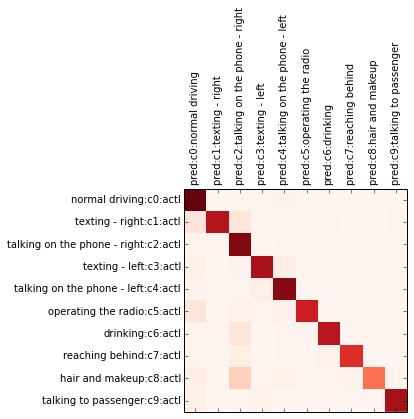


  Vld  logLoss:2.2693
[ 0.0784  0.3528  0.0554  0.1143  0.072   0.3654  0.2822  0.1325  0.6491
  0.1672]


max Pby for cls: c0; desc: normal driving; proba: 1.0000; nObs: 544
  img_62023.jpg:
  plot_occlusion:


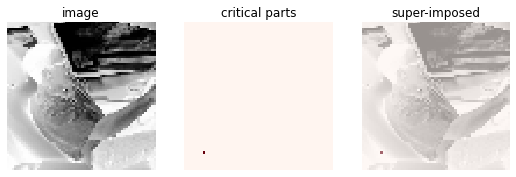

  Proba:
[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
min Pby for cls: c0; desc: normal driving; proba: 0.5015; nObs: 1
  img_42021.jpg:
  plot_occlusion:


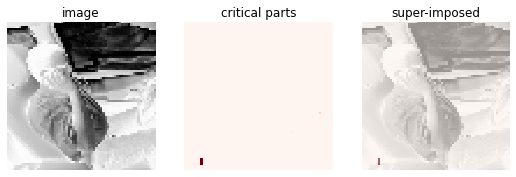

  Proba:
[ 0.5015  0.      0.      0.4985  0.      0.      0.      0.      0.      0.    ]
  next best class: texting - left


max Pby for cls: c1; desc: texting - right; proba: 1.0000; nObs: 324
  img_89322.jpg:
  plot_occlusion:


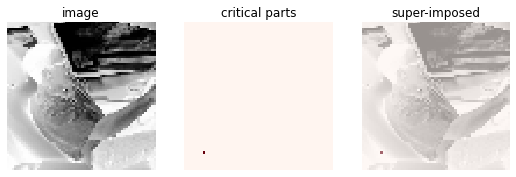

  Proba:
[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
min Pby for cls: c1; desc: texting - right; proba: 0.4830; nObs: 1
  img_53278.jpg:
  plot_occlusion:


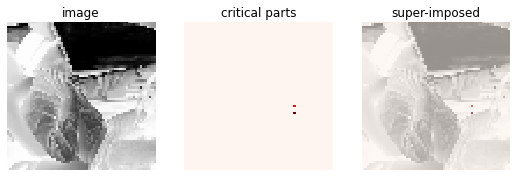

  Proba:
[ 0.      0.483   0.4786  0.      0.      0.      0.0384  0.      0.      0.    ]
  next best class: talking on the phone - right


max Pby for cls: c2; desc: talking on the phone - right; proba: 1.0000; nObs: 516
  img_29251.jpg:
  plot_occlusion:


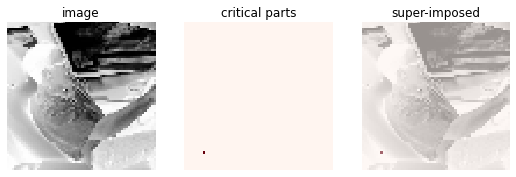

  Proba:
[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
min Pby for cls: c2; desc: talking on the phone - right; proba: 0.5396; nObs: 1
  img_2556.jpg:
  plot_occlusion:


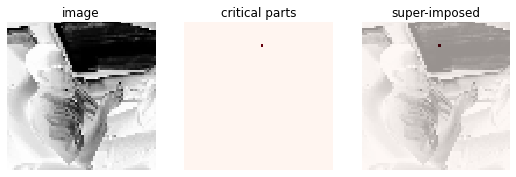

  Proba:
[ 0.      0.      0.5396  0.      0.      0.      0.      0.      0.4604
  0.    ]
  next best class: hair and makeup


max Pby for cls: c3; desc: texting - left; proba: 1.0000; nObs: 366
  img_77361.jpg:
  plot_occlusion:


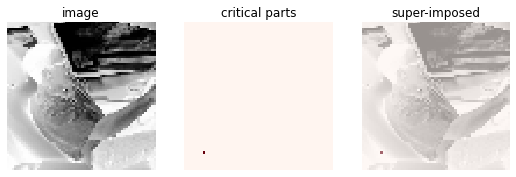

  Proba:
[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
min Pby for cls: c3; desc: texting - left; proba: 0.5115; nObs: 1
  img_56078.jpg:
  plot_occlusion:


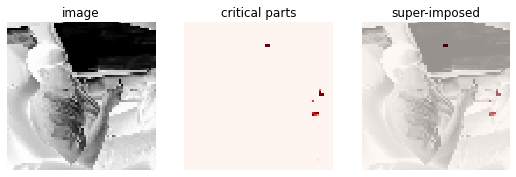

  Proba:
[ 0.4885  0.      0.      0.5115  0.      0.      0.      0.      0.      0.    ]
  next best class: normal driving


max Pby for cls: c4; desc: talking on the phone - left; proba: 1.0000; nObs: 431
  img_93682.jpg:
  plot_occlusion:


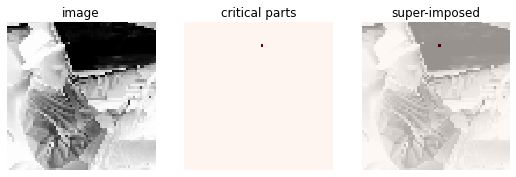

  Proba:
[ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
min Pby for cls: c4; desc: talking on the phone - left; proba: 0.5051; nObs: 1
  img_44591.jpg:
  plot_occlusion:


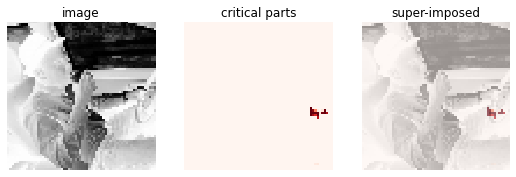

  Proba:
[ 0.0001  0.      0.      0.      0.5051  0.4947  0.      0.      0.      0.    ]
  next best class: operating the radio


max Pby for cls: c5; desc: operating the radio; proba: 1.0000; nObs: 312
  img_70461.jpg:
  plot_occlusion:


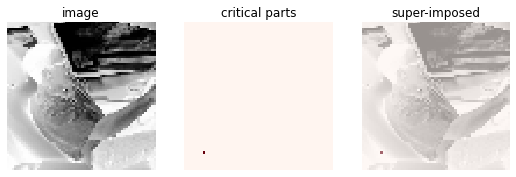

  Proba:
[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
min Pby for cls: c5; desc: operating the radio; proba: 0.5686; nObs: 1
  img_75836.jpg:
  plot_occlusion:


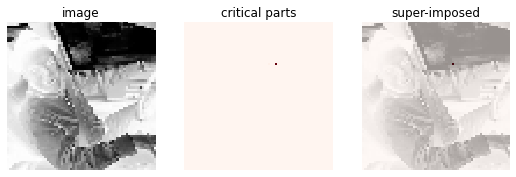

  Proba:
[ 0.001   0.      0.4303  0.      0.      0.5686  0.      0.      0.      0.    ]
  next best class: talking on the phone - right


max Pby for cls: c6; desc: drinking; proba: 1.0000; nObs: 324
  img_68722.jpg:
  plot_occlusion:


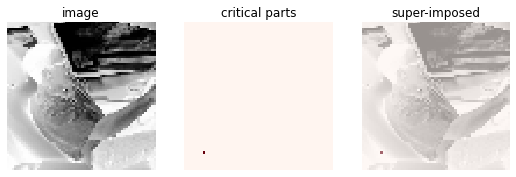

  Proba:
[ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
min Pby for cls: c6; desc: drinking; proba: 0.5091; nObs: 1
  img_98407.jpg:
  plot_occlusion:


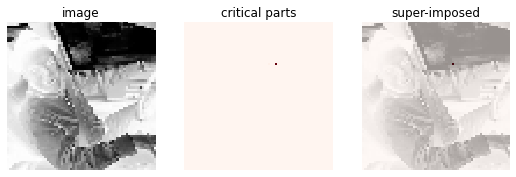

  Proba:
[ 0.      0.      0.4909  0.      0.      0.      0.5091  0.      0.      0.    ]
  next best class: talking on the phone - right


max Pby for cls: c7; desc: reaching behind; proba: 1.0000; nObs: 297
  img_94744.jpg:
  plot_occlusion:


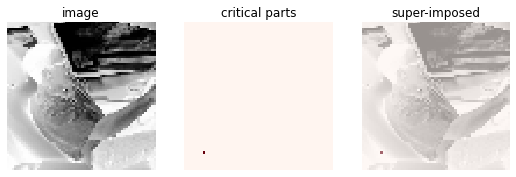

  Proba:
[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
min Pby for cls: c7; desc: reaching behind; proba: 0.6377; nObs: 1
  img_71088.jpg:
  plot_occlusion:


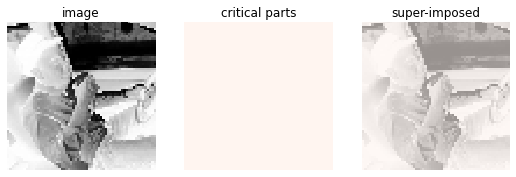

  Proba:
[ 0.      0.      0.      0.      0.      0.      0.3623  0.6377  0.      0.    ]
  next best class: drinking


max Pby for cls: c8; desc: hair and makeup; proba: 1.0000; nObs: 176
  img_8759.jpg:
  plot_occlusion:


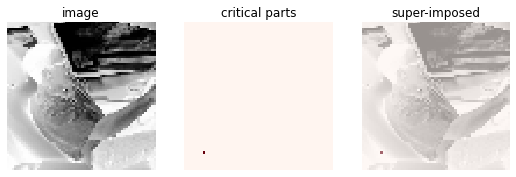

  Proba:
[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
min Pby for cls: c8; desc: hair and makeup; proba: 0.5385; nObs: 1
  img_90602.jpg:
  plot_occlusion:


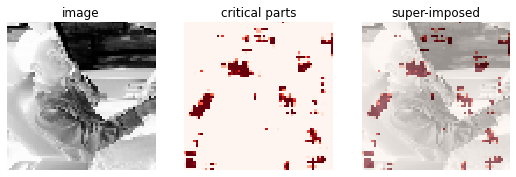

  Proba:
[ 0.      0.      0.      0.      0.      0.      0.      0.      0.5385
  0.4615]
  next best class: talking to passenger


max Pby for cls: c9; desc: talking to passenger; proba: 1.0000; nObs: 349
  img_24934.jpg:
  plot_occlusion:


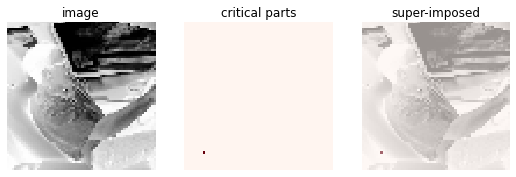

  Proba:
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
min Pby for cls: c9; desc: talking to passenger; proba: 0.6220; nObs: 1
  img_56862.jpg:
  plot_occlusion:


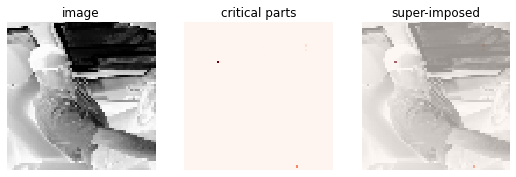

  Proba:
[ 0.378  0.     0.     0.     0.     0.     0.     0.     0.     0.622]
  next best class: normal driving
  predicting 79726 new obs...
    @  115 secs: obsIx:     0
    @  118 secs: obsIx:  8000
    @  127 secs: obsIx: 40000


max Pby for cls: c0; desc: normal driving; proba: 1.0000; nObs: 8853
  img_100.jpg:
  plot_occlusion:


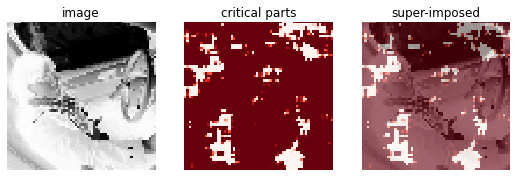

  Proba:
[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
min Pby for cls: c0; desc: normal driving; proba: 0.4057; nObs: 1
  img_76637.jpg:
  plot_occlusion:


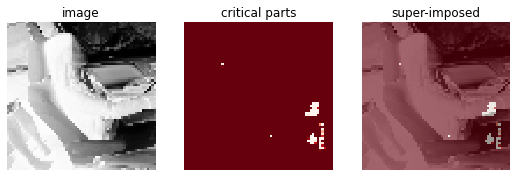

  Proba:
[ 0.4057  0.      0.      0.3717  0.      0.      0.      0.      0.2226
  0.    ]
  next best class: texting - left


max Pby for cls: c1; desc: texting - right; proba: 1.0000; nObs: 4782
  img_100019.jpg:
  plot_occlusion:


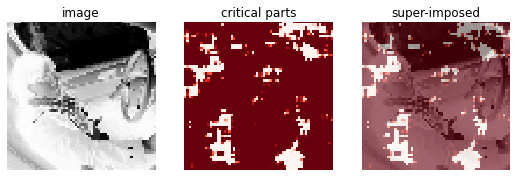

  Proba:
[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
min Pby for cls: c1; desc: texting - right; proba: 0.4077; nObs: 1
  img_4737.jpg:
  plot_occlusion:


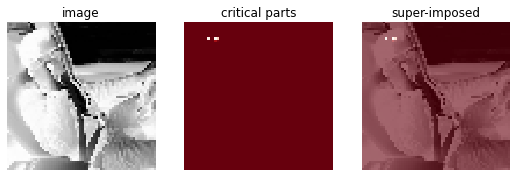

  Proba:
[ 0.      0.4077  0.      0.      0.3405  0.2518  0.      0.      0.      0.    ]
  next best class: talking on the phone - left


max Pby for cls: c2; desc: talking on the phone - right; proba: 1.0000; nObs: 3537
  img_100014.jpg:
  plot_occlusion:


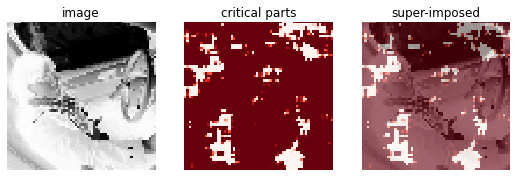

  Proba:
[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
min Pby for cls: c2; desc: talking on the phone - right; proba: 0.3901; nObs: 1
  img_19128.jpg:
  plot_occlusion:


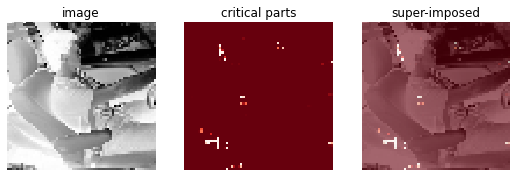

  Proba:
[ 0.      0.      0.3901  0.2967  0.3132  0.      0.      0.      0.      0.    ]
  next best class: talking on the phone - left


max Pby for cls: c3; desc: texting - left; proba: 1.0000; nObs: 4391
  img_100013.jpg:
  plot_occlusion:


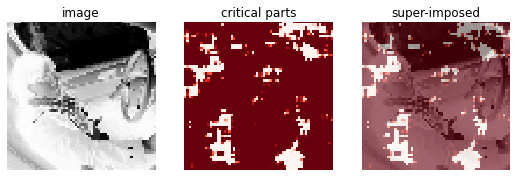

  Proba:
[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
min Pby for cls: c3; desc: texting - left; proba: 0.3671; nObs: 1
  img_91136.jpg:
  plot_occlusion:


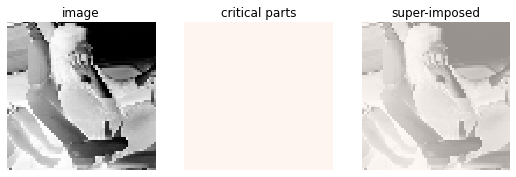

  Proba:
[ 0.      0.3616  0.      0.3671  0.2713  0.      0.      0.      0.      0.    ]
  next best class: texting - right


max Pby for cls: c4; desc: talking on the phone - left; proba: 1.0000; nObs: 8163
  img_100000.jpg:
  plot_occlusion:


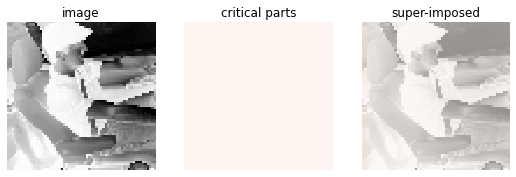

  Proba:
[ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
min Pby for cls: c4; desc: talking on the phone - left; proba: 0.3482; nObs: 1
  img_49718.jpg:
  plot_occlusion:


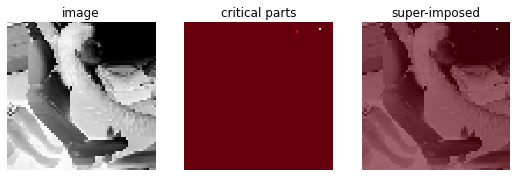

  Proba:
[ 0.3059  0.      0.      0.3459  0.3482  0.      0.      0.      0.      0.    ]
  next best class: texting - left


max Pby for cls: c5; desc: operating the radio; proba: 1.0000; nObs: 3951
  img_10.jpg:
  plot_occlusion:


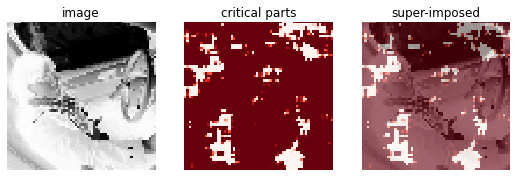

  Proba:
[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
min Pby for cls: c5; desc: operating the radio; proba: 0.4102; nObs: 1
  img_92348.jpg:
  plot_occlusion:


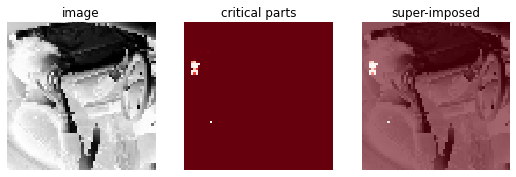

  Proba:
[ 0.0104  0.2268  0.      0.      0.      0.4102  0.3525  0.      0.      0.    ]
  next best class: drinking


max Pby for cls: c6; desc: drinking; proba: 1.0000; nObs: 3437
  img_100002.jpg:
  plot_occlusion:


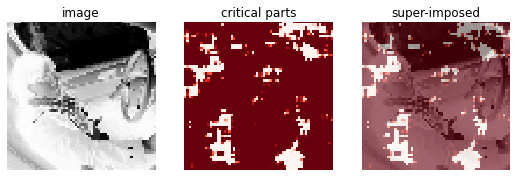

  Proba:
[ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
min Pby for cls: c6; desc: drinking; proba: 0.3780; nObs: 1
  img_22607.jpg:
  plot_occlusion:


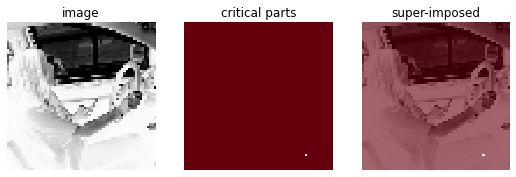

  Proba:
[ 0.      0.      0.      0.3176  0.3044  0.      0.378   0.      0.      0.    ]
  next best class: texting - left


max Pby for cls: c7; desc: reaching behind; proba: 1.0000; nObs: 5482
  img_100003.jpg:
  plot_occlusion:


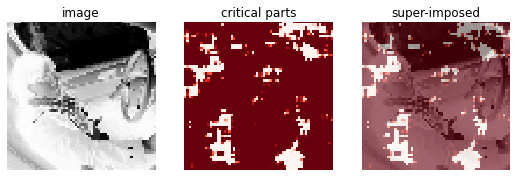

  Proba:
[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
min Pby for cls: c7; desc: reaching behind; proba: 0.4260; nObs: 1
  img_9871.jpg:
  plot_occlusion:


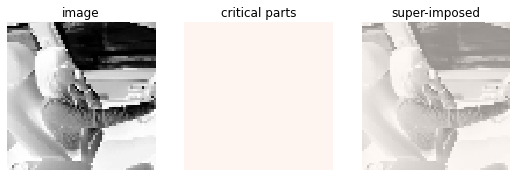

  Proba:
[ 0.      0.      0.      0.      0.4137  0.      0.1603  0.426   0.      0.    ]
  next best class: talking on the phone - left


max Pby for cls: c8; desc: hair and makeup; proba: 1.0000; nObs: 3551
  img_1000.jpg:
  plot_occlusion:


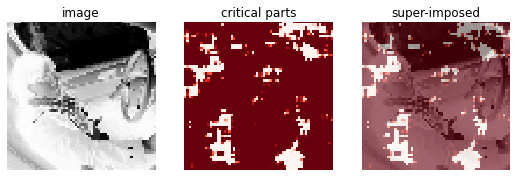

  Proba:
[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
min Pby for cls: c8; desc: hair and makeup; proba: 0.4220; nObs: 1
  img_3946.jpg:
  plot_occlusion:


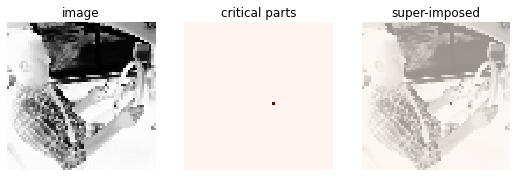

  Proba:
[ 0.2485  0.      0.3295  0.      0.      0.      0.      0.      0.422   0.    ]
  next best class: talking on the phone - right


max Pby for cls: c9; desc: talking to passenger; proba: 1.0000; nObs: 6390
  img_100012.jpg:
  plot_occlusion:


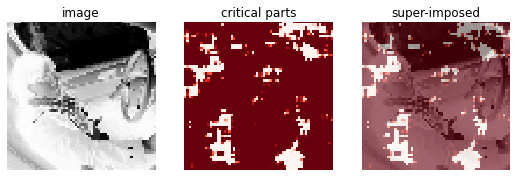

  Proba:
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
min Pby for cls: c9; desc: talking to passenger; proba: 0.3895; nObs: 1
  img_53999.jpg:
  plot_occlusion:


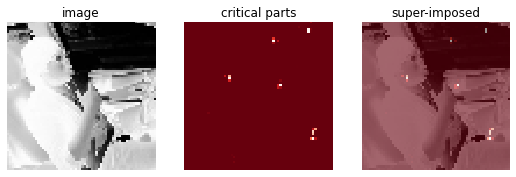

  Proba:
[ 0.      0.      0.2556  0.      0.      0.      0.      0.      0.3549
  0.3895]
  next best class: hair and makeup

  New prediction knts:
{'kntCls': (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([12727,  7590,  6021,  6939, 12326,  5672,  5611,  7488,  5657,  9695]))}
  duration: 186 seconds


In [20]:
finMdlDf, finYVldPby, finYNewPby = fitMdlMLPRELUSGDTfw(
    glbXTrn, glbYTrn, 
    nObsFit = glbXTrn.shape[0], 
    nObsBtc = selMdlSrs['nObsBtc'][0],     
    rotatePby = selMdlSrs['rotatePby'][0],     
    rotateMaxAgl = selMdlSrs['rotateMaxAgl'][0],
    nRELUs = selMdlSrs['nRELUs'][0],
    nStepsTfw = selMdlSrs['nStepsTfw'][0], 
    lrnRateTfw = selMdlSrs['lrnRateTfw'][0],     
    visualize = True, newObs = True, verbose = True)

# selMdlDf, selYVldPby, selYNewPby = fitMdlMLPRELUSGDTfw(
#     glbXFit, glbYFit, 
#     nObsFit = glbXFit.shape[0], 
#     nObsBtc = selMdlSrs['nObsBtc'][0],     
#     rotatePby = selMdlSrs['rotatePby'][0],     
#     rotateMaxAgl = selMdlSrs['rotateMaxAgl'][0],
#     nRELUs = selMdlSrs['nRELUs'][0],
#     nStepsTfw = selMdlSrs['nStepsTfw'][0], 
#     lrnRateTfw = selMdlSrs['lrnRateTfw'][0], 
#     visualize = True, newObs = True, verbose = True)

In [21]:
print finMdlDf

            id  lrnRateTfw  nObsBtc  nObsFit  nRELUs  nStepsTfw  rotateMaxAgl  \
0  MLP.SGD.tfw        0.01      8.0    22424     512       2804             2   

   rotatePby    accVld                                          accVldCls  \
0        0.1  0.875546  {u'accCls': [0.964876033058, 0.807531380753, 0...   

   logLossVld                                      logLossVldCls  \
0    2.269303  {u'logLossCls': [0.0784283472503, 0.3528235715...   

                                             predNew  \
0  {u'kntCls': ([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], [...   

                                               model  duration  
0  <tensorflow.python.client.session.Session obje...       186  


In [22]:
glbMdlDf = glbMdlDf.append(finMdlDf)
glbMdlDf = glbMdlDf.set_index(['id'] + srchParamsDct.keys(), drop = False)
glbMdlDf = glbMdlDf.sort_values(
                ['nObsFit', 'accVld', 'logLossVld', 'duration'], 
    ascending = [False    , True    , False,        False])
print(glbMdlDf[list(set(glbMdlDf.columns) - 
                    set(['id'] + srchParamsDct.keys()))])

                                                                                                                           accVldCls  \
id             nStepsTfw nObsFit nRELUs rotatePby nObsBtc lrnRateTfw rotateMaxAgl                                                      
LgtRgr.SGD.tfw  2804.0   22424.0 0      0.1       8.0      3.00      2             {u'accCls': [0.704545454545, 0.910041841004, 0...   
MLP.SGD.tfw     2804.0   22424.0 512    0.1       8.0      0.01      2             {u'accCls': [0.964876033058, 0.807531380753, 0...   
LgtRgr.tfw      1000.0   22424.0 0      0.0       22424.0  10.00     0             {u'accCls': [0.989669421488, 0.991631799163, 0...   
LgtRgr.skl     -1.0      22424.0 0      0.0       22424.0 -1.00      0                                                           NaN   
MLP.SGD.tfw     2260.0   18077.0 512    0.1       16.0     3.00      2             {u'accCls': [0.0, 0.0, 0.0, 0.0, 0.0, 0.997630...   
                                 256    0.1     

In [23]:
myexportDf(glbMdlDf, 
           save_filepathname = glbPickleFile['models'],
           save_drop_cols = 'model'
          )

Compressed pickle file: data/img_M_SFDD_ImgSz_64.pickle; size: 82 KB


## Output submission

In [24]:
print '\n finMdl:'
glbwriteSubmission(glbINew, finYNewPby, 
    'img_05_fit_MLP_RELU_SGD_Tfw_SFDD_ImgSz_' + str(glbImg['size']) + \
                   '_sbmt_fin.csv')


 finMdl:
                           img            c0            c1            c2  \
img                                                                        
img_1.jpg            img_1.jpg  0.000000e+00  0.000000e+00  7.971826e-24   
img_10.jpg          img_10.jpg  0.000000e+00  0.000000e+00  0.000000e+00   
img_100.jpg        img_100.jpg  1.000000e+00  9.116128e-37  0.000000e+00   
img_1000.jpg      img_1000.jpg  1.743113e-28  9.551511e-21  3.102363e-30   
img_100000.jpg  img_100000.jpg  0.000000e+00  0.000000e+00  0.000000e+00   

                          c3            c4        c5            c6  \
img                                                                  
img_1.jpg       0.000000e+00  8.145913e-01  0.185401  1.367235e-32   
img_10.jpg      7.174043e-17  0.000000e+00  1.000000  0.000000e+00   
img_100.jpg     0.000000e+00  0.000000e+00  0.000000  0.000000e+00   
img_1000.jpg    0.000000e+00  1.415086e-12  0.000000  8.433488e-21   
img_100000.jpg  4.250266e-11  1.00000

In [25]:
prtStr = 'LeaderBoard metric for this sel submission: %0.5f vs. ' + \
        'logLossVld (sel): %0.5f'
print prtStr % (22.72890, 19.7827)
prtStr = 'LeaderBoard metric for this fin submission: %0.5f vs. ' + \
        'logLossVld (fin): %0.5f'
print prtStr % (21.78494,  2.2693)
print 'Best score yet:%s: %0.5f' % \
    ('img_02_fit_lgtRgr(Skl)_SFDD_(ImgSz_32_)sbmt(_fin).csv', 2.63892)

LeaderBoard metric for this sel submission: 22.72890 vs. logLossVld (sel): 19.78270
LeaderBoard metric for this fin submission: 21.78494 vs. logLossVld (fin): 2.26930
Best score yet:img_02_fit_lgtRgr(Skl)_SFDD_(ImgSz_32_)sbmt(_fin).csv: 2.63892


## Stop here

Following code should be in img_04_fit_lgtRgrSGDTf_<projectId>

Let's now switch to stochastic gradient descent training instead, which is much faster.

The graph will be similar, except that instead of holding all the training data into a constant node, we create a `Placeholder` node which will be fed actual data at every call of `sesion.run()`.

In [6]:
import pandas as pd
models = pd.DataFrame({'nRELUs': [0]})
#models.ix[0, 'accuracy_scoreTest'] = 0
print models

   nRELUs
0       0


In [7]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tfwObsFitFtr = tf.placeholder(tf.float32,
                                    shape=(batch_size, glbImg['size'] * glbImg['size']))
  tfwObsFitRsp = tf.placeholder(tf.float32, shape=(batch_size, glbRspClassN))
  tfwObsVldFtr = tf.constant(glbXVld)
  tfwObsNewFtr = tf.constant(glbXNew)
  
  # Variables.
  tfwW = tf.Variable(
    tf.truncated_normal([glbImg['size'] * glbImg['size'], glbRspClassN]))
  tfwB = tf.Variable(tf.zeros([glbRspClassN]))
  print(tfwW.initialized_value())
  print(tfwB.initialized_value())    
  
  # Training computation.
  logits = tf.matmul(tfwObsFitFtr, tfwW) + tfwB
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tfwObsFitRsp))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  tfwObsTrnPred = tf.nn.softmax(logits)
  tfwObsVldPred = tf.nn.softmax(
    tf.matmul(tfwObsVldFtr, tfwW) + tfwB)
  tfwObsNewPred = tf.nn.softmax(tf.matmul(tfwObsNewFtr, tfwW) + tfwB)

Tensor("Identity:0", shape=TensorShape([Dimension(784), Dimension(10)]), dtype=float32)
Tensor("Identity_1:0", shape=TensorShape([Dimension(10)]), dtype=float32)


Let's run it:

In [8]:
nStepsTfw = 3001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(nStepsTfw):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (glbYFit.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = glbXFit[offset:(offset + batch_size), :]
    batch_labels = glbYFit[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tfwObsFitFtr : batch_data, tfwObsFitRsp : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, tfwObsTrnPred], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy_score: %.1f%%" % accuracy_score(predictions, batch_labels))
      print("Validation accuracy_score: %.1f%%" % accuracy_score(
        tfwObsVldPred.eval(), glbYVld))
  print("Test accuracy_score: %.1f%%" % accuracy_score(tfwObsNewPred.eval(), glbYNew))
  models.ix[0, 'accuracy_scoreVld'] = accuracy_score(tfwObsVldPred.eval(), glbYVld)
  models.ix[0, 'accuracy_scoreTst'] = accuracy_score( tfwObsNewPred.eval(),  glbYNew)

Initialized
Minibatch loss at step 0: 17.272371
Minibatch accuracy: 6.2%
Validation accuracy: 13.0%
Minibatch loss at step 500: 1.435902
Minibatch accuracy: 76.6%
Validation accuracy: 75.2%
Minibatch loss at step 1000: 1.280029
Minibatch accuracy: 78.1%
Validation accuracy: 77.2%
Minibatch loss at step 1500: 1.147653
Minibatch accuracy: 77.3%
Validation accuracy: 77.2%
Minibatch loss at step 2000: 1.262677
Minibatch accuracy: 72.7%
Validation accuracy: 77.9%
Minibatch loss at step 2500: 0.777248
Minibatch accuracy: 83.6%
Validation accuracy: 77.3%
Minibatch loss at step 3000: 1.085464
Minibatch accuracy: 77.3%
Validation accuracy: 78.6%
Test accuracy: 86.1%


In [9]:
models.ix[0, 'graph'] = graph
print(models)

   nRELUs  accuracyVld  accuracyTst  \
0       0        78.57    86.098056   

                                               graph  
0  <tensorflow.python.framework.ops.Graph object ...  


---
Problem
-------

Turn the logistic regression example with SGD into a 1-hidden layer neural network with rectified linear units (nn.relu()) and 1024 hidden nodes. This model should improve your validation / test accuracy_score.

---

In [10]:
nRELUs = [2 ** thsRelu for thsRelu in xrange(11)]
print(nRELUs)
for thsRelu in nRELUs:
    models.ix[thsRelu, 'nRELUs'] = thsRelu

print models

[1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
      nRELUs  accuracyVld  accuracyTst  \
0          0        78.57    86.098056   
1          1          NaN          NaN   
2          2          NaN          NaN   
4          4          NaN          NaN   
8          8          NaN          NaN   
16        16          NaN          NaN   
32        32          NaN          NaN   
64        64          NaN          NaN   
128      128          NaN          NaN   
256      256          NaN          NaN   
512      512          NaN          NaN   
1024    1024          NaN          NaN   

                                                  graph  
0     <tensorflow.python.framework.ops.Graph object ...  
1                                                   NaN  
2                                                   NaN  
4                                                   NaN  
8                                                   NaN  
16                                                  NaN  
3

In [49]:
thsRelu = nRELUs[9]
batch_size = 128

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tfwObsFitFtr = tf.placeholder(tf.float32,
                                    shape=(batch_size, glbImg['size'] * glbImg['size']))
  tfwObsFitRsp = tf.placeholder(tf.float32, shape=(batch_size, glbRspClassN))
  tfwObsVldFtr = tf.constant(glbXVld)
  tfwObsNewFtr = tf.constant(glbXNew)
  
  # Variables.
  tfwW1 = tf.Variable(
    tf.truncated_normal([glbImg['size'] * glbImg['size'], thsRelu]), name = 'tfwW1')
  tfwB1 = tf.Variable(tf.zeros([thsRelu]), name = 'tfwB1')
  tfwW2 = tf.Variable(
    tf.truncated_normal([thsRelu, glbRspClassN]), name = 'tfwW2')
  tfwB2 = tf.Variable(tf.zeros([glbRspClassN]), name = 'tfwB2')
  print(tfwW1.initialized_value())
  print(tfwB1.initialized_value())
  #print(relus.initialized_value())
  print(tfwW2.initialized_value())
  print(tfwB2.initialized_value())
  #tf.Print(relus, [relus])  
     
  # Training computation.
  layer1 = tf.matmul(tfwObsFitFtr, tfwW1) + tfwB1
  layer2 = tf.nn.relu(layer1)
  layer3 = tf.matmul(layer2, tfwW2) + tfwB2
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(layer3, tfwObsFitRsp))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  tfwObsTrnPred = tf.nn.softmax(layer3)
  tfwObsVldPred = tf.nn.softmax(
    tf.matmul(tf.nn.relu(tf.matmul(tfwObsVldFtr, tfwW1) + tfwB1), tfwW2) + tfwB2)
  tfwObsNewPred = tf.nn.softmax(
    tf.matmul(tf.nn.relu(tf.matmul(tfwObsNewFtr, tfwW1) + tfwB1), tfwW2) + tfwB2)

Tensor("Identity:0", shape=TensorShape([Dimension(784), Dimension(512)]), dtype=float32)
Tensor("Identity_1:0", shape=TensorShape([Dimension(512)]), dtype=float32)
Tensor("Identity_2:0", shape=TensorShape([Dimension(512), Dimension(10)]), dtype=float32)
Tensor("Identity_3:0", shape=TensorShape([Dimension(10)]), dtype=float32)


In [50]:
nStepsTfw = 3001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(nStepsTfw):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (glbYFit.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = glbXFit[offset:(offset + batch_size), :]
    batch_labels = glbYFit[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tfwObsFitFtr : batch_data, tfwObsFitRsp : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, tfwObsTrnPred], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy_score: %.1f%%" % accuracy_score(predictions, batch_labels))
      print("Validation accuracy_score: %.1f%%" % accuracy_score(
        tfwObsVldPred.eval(), glbYVld))
  print("Test accuracy_score: %.1f%%" % accuracy_score(tfwObsNewPred.eval(), glbYNew))
  models.ix[thsRelu, 'accuracy_scoreVld'] = accuracy_score(tfwObsVldPred.eval(), glbYVld)
  models.ix[thsRelu, 'accuracy_scoreTst'] = accuracy_score( tfwObsNewPred.eval(),  glbYNew)
  models.ix[thsRelu, 'graph'] = graph
  print(models)

Initialized
Minibatch loss at step 0: 235.251495
Minibatch accuracy: 14.1%
Validation accuracy: 23.9%
Minibatch loss at step 500: 15.635325
Minibatch accuracy: 72.7%
Validation accuracy: 77.7%
Minibatch loss at step 1000: 5.719280
Minibatch accuracy: 83.6%
Validation accuracy: 78.3%
Minibatch loss at step 1500: 3.931793
Minibatch accuracy: 76.6%
Validation accuracy: 75.8%
Minibatch loss at step 2000: 3.211185
Minibatch accuracy: 75.0%
Validation accuracy: 78.1%
Minibatch loss at step 2500: 1.988469
Minibatch accuracy: 80.5%
Validation accuracy: 78.0%
Minibatch loss at step 3000: 3.435107
Minibatch accuracy: 77.3%
Validation accuracy: 79.1%
Test accuracy: 86.7%
      nRELUs  accuracyVld  accuracyTst  \
0          0        78.57    86.098056   
1          1        19.29    19.750053   
2          2        36.26    40.087588   
4          4        64.67    71.122623   
8          8        75.80    82.861568   
16        16        79.74    86.685537   
32        32        76.77    84.28754

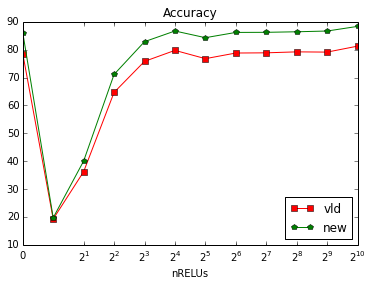

In [52]:
plt.figure()
#plt.plot(models['nRELUs'], models['accuracy_score.fit'], 'bo-', label = 'fit')
plt.plot(models['nRELUs'], models['accuracy_scoreVld'], 'rs-', label = 'vld')
plt.plot(models['nRELUs'], models['accuracy_scoreTst'], 'gp-', label = 'new')
plt.legend(loc = 'lower right')
plt.title("accuracy_score")
plt.xscale('symlog', basex=2)
axes = plt.gca()
axes.set_xlabel('nRELUs')
# axes.set_xlim([mdlDF['l1_penalty'][mdlDF['RSS.vld'].argmin()] / 10 ** 2, \
#                mdlDF['l1_penalty'][mdlDF['RSS.vld'].argmin()] * 10 ** 2])
# axes.set_ylim([0, mdlDF['RSS.vld'].min() * 1.5])
plt.show()